# Анализ удовлетворённости сотрудников компании

HR-аналитики компании "Работа с заботой" помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.  
Компания предоставила данные с характеристиками сотрудников компании. Среди них - уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 - совершенно неудовлетворён, 1 - полностью удовлетворён. Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли.  

Первая задача - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Эта информация важна, так как удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока - одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.  
Вторая задача - построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.  

**План работы.**

Задача 1. Предсказание уровня удовлетворённости сотрудника
1. Загрузить данные.
2. Ознакомиться с данными и выполнить их предобработку.
3. Провести исследовательский анализ данных.
4. Выполнить подготовку данных.
5. Обучить модели с использованией пайплайнов, подобрать гиперпараметры, выбрать лучшую модель и проверить её качество.
6. Оформить выводы.

Задача 2. Предсказание увольнения сотрудника из компании
1. Загрузить данные
2. Ознакомиться с данными и выполнить их предобработку.
3. Провести исследовательский анализ данных. Составить портрет "уволившегося сотрудника".
4. Выполнить подготовку данных.
5. Обучить модели с использованием пайплайнов. Проверить качество лучшей модели.
6. Оформить выводы.

**Описание данных.**  

Для первой задачи заказчик предоставил данные в датафреймах:  
`train_job_satisfaction_rate.csv`,  
`test_features.csv`,  
`test_target_job_satisfaction_rate.csv`.  
Столбцы в датафреймах:    
`id` — уникальный идентификатор сотрудника;  
`dept` — отдел, в котором работает сотрудник;  
`level` — уровень занимаемой должности;  
`workload` — уровень загруженности сотрудника;  
`employment_years` — длительность работы в компании (в годах);  
`last_year_promo` — показывает, было ли повышение за последний год;  
`last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;  
`supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;  
`salary` — ежемесячная зарплата сотрудника;  
`job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.  

Для второй задачи заказчик предоставил данные в датафреймах:  
`train_quit.csv`,  
`test_features.csv`,  
`test_target_quit.csv`.  
Столбцы аналогичные, дополнительно имеется столбец:  
`quit` - факт увольнения сотрудника из компании.

In [1]:
# Если версия sklearn старая, необходимо обновить
#!pip install scikit-learn==1.4

In [2]:
import pandas as pd
import numpy as np

try:
    import matplotlib.pyplot as plt
except:
    !pip install --upgrade matplotlib==3.8.4
    import matplotlib.pyplot as plt

try:
    import seaborn as sns
except:
    !pip install --upgrade seaborn==0.13
    import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor, DummyClassifier
from scipy import stats as st


try:
    import shap
except:
    !pip install shap
    import shap

try:
    import phik
except:
    !pip install phik
    import phik

from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

## Предсказание уровня удовлетворённости сотрудника
### Загрузка данных

In [3]:
# Формула для оптимизации кода вывода первичной информации
def information(dataset):
    display(dataset.head())
    display()
    display(dataset.info())

In [4]:
# Загрузим тренировочную выборку, сохраним её в датафрейм `train_satisfaction`
try:
    train_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
except:
    train_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')

# Изучим общую информацию о датафрейме `train_satisfaction`
information(train_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

In [5]:
# Загрузим входные признаки тестовой выборки, сохраним его в датафрейм `test_features`
try:
    test_features = pd.read_csv('/datasets/test_features.csv')
except:
    test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')

# Изучим общую информацию о датафрейме `test_features`
information(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

In [6]:
# Загрузим целевой признак тестовой выборки, сохраним его в датафрейм `test_target_satisfaction`
try:
    test_target_satisfaction = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    test_target_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

# Изучим общую информацию о датафрейме `test_target_satisfaction`
information(test_target_satisfaction)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

Итак, данные загружены.

### Предобработка данных
Данные содержатся в трёх датафреймах, отдельно тренировочная выборка, отдельно тестовая и отдельно целевой признак тестовой выборки.  
В тренировочной выборке 4000 строк и 10 столбцов. В тестовой выборке 2000 строк, таблица с входными признаками содержит 9 столбцов, с целевым признаком - 2 столбца.  
Объединим два тестовых датафрейма в один датафрейм `test_data`.

In [7]:
test_satisfaction = test_features.merge(test_target_satisfaction, on='id')
information(test_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


None

Названия столбцов обработки не требуют. И они идентичны в тренировочной и тестовой выборках.  Проверим данные на наличие пропусков и дубликатов.

In [8]:
# Создаём словарь датафреймов `dfs`
dfs = {
    'train_satisfaction': train_satisfaction,
    'test_satisfaction': test_satisfaction
}

# Создаём цикл для проверки на наличие пропусков, явных и неявных дубликатов в датафреймах из словаря `dfs`
for name, df in dfs.items():
    print(f'Название датафрейма: {name}\n')
    print(f'Количество пропусков\n{df.isna().sum()}\n')
    print(f'Количество дубликатов {df.duplicated().sum()}\n')
    print('Уникальные значения в категориальных столбцах:')
    df_cat = df.select_dtypes(include=['object'])
    for column in df_cat.columns:
        print(f'столбец "{column}": {df_cat[column].unique()}')
    print('-' * 40)

Название датафрейма: train_satisfaction

Количество пропусков
id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Количество дубликатов 0

Уникальные значения в категориальных столбцах:
столбец "dept": ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
столбец "level": ['junior' 'middle' 'sinior' nan]
столбец "workload": ['medium' 'high' 'low']
столбец "last_year_promo": ['no' 'yes']
столбец "last_year_violations": ['no' 'yes']
----------------------------------------
Название датафрейма: test_satisfaction

Количество пропусков
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary      

Явных и неявных дубликатов нет. Пропуски имеются в категориальных столбцах. Кроме того, в датафрейме `test_satisfaction` есть строки, имеющие значением пробел. Заменим строки с пробелами на `nan`. Исправим грамматическую ошибку в слове `senior`.

In [9]:
# Заменим пробелы на nan методом replace()
test_satisfaction['dept'] = test_satisfaction['dept'].replace(' ', np.nan, regex= True)
test_satisfaction['workload'] = test_satisfaction['workload'].replace(' ', np.nan, regex= True)

# Исправим грамматическую ошибку
train_satisfaction['level'] = train_satisfaction['level'].replace('sinior', 'senior', regex= True)
test_satisfaction['level'] = test_satisfaction['level'].replace('sinior', 'senior', regex= True)

# Проверим
print("Уникальные значения в столбце 'dept' таблицы 'test_satisfaction'", test_satisfaction['dept'].unique())
print("Уникальные значения в столбце 'workload' таблицы 'test_satisfaction'", test_satisfaction['workload'].unique())
print("Уникальные значения в столбце 'level' таблицы 'train_satisfaction'", train_satisfaction['level'].unique())
print("Уникальные значения в столбце 'level' таблицы 'test_satisfaction'", test_satisfaction['level'].unique())

Уникальные значения в столбце 'dept' таблицы 'test_satisfaction' ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения в столбце 'workload' таблицы 'test_satisfaction' ['medium' 'low' 'high' nan]
Уникальные значения в столбце 'level' таблицы 'train_satisfaction' ['junior' 'middle' 'senior' nan]
Уникальные значения в столбце 'level' таблицы 'test_satisfaction' ['junior' 'middle' 'senior' nan]


In [10]:
# Сделаем столбец `id` в каждом датафрейме индексами
train_data = train_satisfaction.set_index('id')
test_data = test_satisfaction.set_index('id')

# Проверим
information(train_data)
information(test_data)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


None

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1997 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               1999 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


None

Пропуски обработаем в пайплайне после исследовательского анализа данных. Пока предварительно набросаем пайплайн.

In [11]:
# Создадим список столбцов с пропущенными значениями
null_columns = ['dept', 'level', 'workload']

# Создадим пайплайн для обработки пропущенных значений
null_pipe = Pipeline(
    [
        (
            'simpleImputer_null',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# Создадим пайплайн, в котором применяем данные к нужным столбцам
change_zeros = ColumnTransformer(
    [
        ('null', null_pipe, null_columns)
    ],
    remainder = 'passthrough'
)

Итак, два датафрейма с тестовыми данными объединили в один, проверили, что столбцы в нём идентичны данным в тренировочном датафрейме.  Проверили данные на дубликаты. Удалили строки с пробелами. Сделали столбец `id` в каждом датафрейме индексами. Подготовили предварительный пайплайн для обработки пропусков.

### Исследовательский анализ данных

In [12]:
# Напишем функцию построения столбчатых диаграмм для категориальных признаков
# здесь же рассчитаем отношение максимального значения к минимальному

# функция принимает на вход признак, название графика, название оси у
def graphic_cat(characteristic, graphic_name, label_name):
    # задаём общую схему графика
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig.suptitle(graphic_name)
    # строим график для трейна
    sns.countplot(data=train_data, y=characteristic, order=train_data[characteristic].value_counts().index, ax=axes[0])
    axes[0].set_title('Тренировочная выборка')
    axes[0].set_xlabel('Количество')
    axes[0].set_ylabel(label_name)
    # строим график для теста
    sns.countplot(data=test_data, y=characteristic, order=train_data[characteristic].value_counts().index, ax=axes[1])
    axes[1].set_title('Тестовая выборка')
    axes[1].set_xlabel('Количество')
    axes[1].set_ylabel(label_name)
    # увеличим расстояние между графиками и выведем графики на экран
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    # рассчитываем соотношение для трейна
    result_train = (train_data.groupby(characteristic)[characteristic].count().max() /\
    train_data.groupby(characteristic)[characteristic].count().min()).round(2)
    print(f'Отношение максимального значения к минимальному в трейне: {result_train}')
    # рассчитываем соотношение для теста
    result_test = (test_data.groupby(characteristic)[characteristic].count().max() /\
    test_data.groupby(characteristic)[characteristic].count().min()).round(2)
    print(f'Отношение максимального значения к минимальному в тесте: {result_test}')

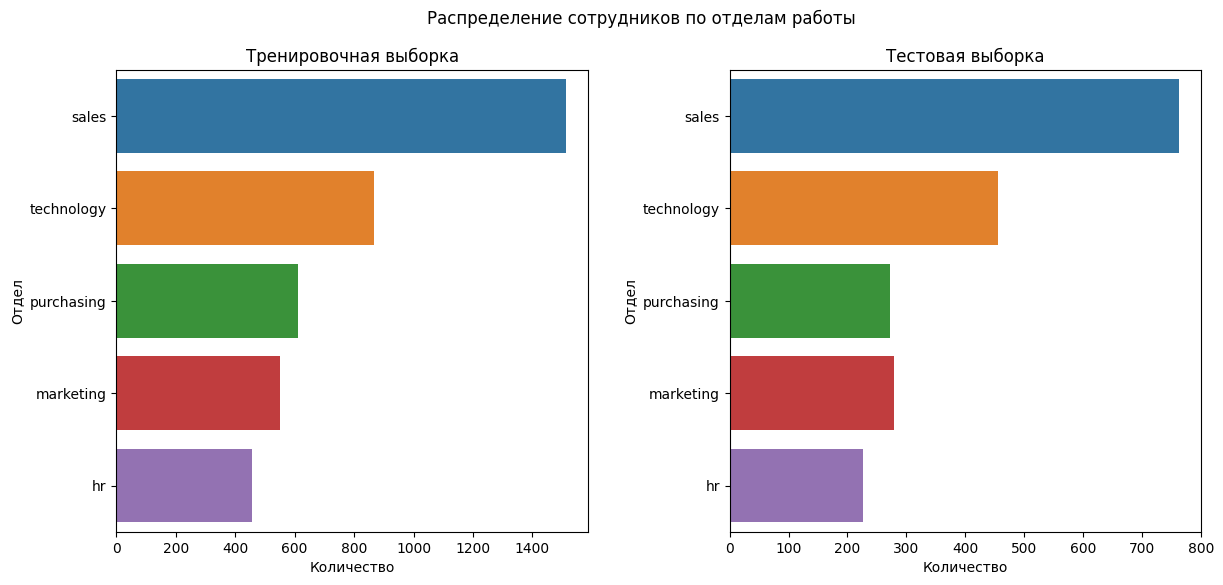

Отношение максимального значения к минимальному в трейне: 3.32
Отношение максимального значения к минимальному в тесте: 3.36


In [13]:
# Построим столбчатые диаграммы распределения сотрудников по отделам, в которых они работают
graphic_cat(
    'dept',
    'Распределение сотрудников по отделам работы',
    'Отдел'
)

Сотрудников в самом многочисленном отделе `sales`работает в 3,32-3,36 раза больше, чем в отделе самом малочисленном отделе `hr`. Распределение в трейне и тесте одинаковое.

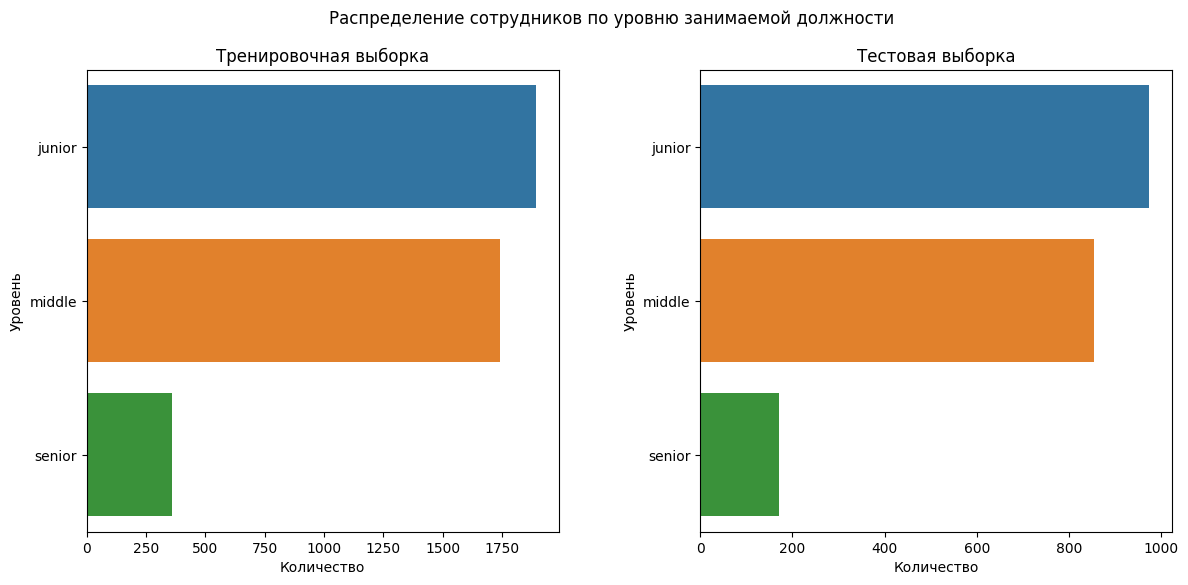

Отношение максимального значения к минимальному в трейне: 5.29
Отношение максимального значения к минимальному в тесте: 5.7


In [14]:
# Построим столбчатую диаграмму распределения сотрудников по уровню занимаемой должности
graphic_cat(
    'level',
    'Распределение сотрудников по уровню занимаемой должности',
    'Уровень'
)

Сотрудников уровней `junior` и `middle` значительно больше, чем сотрудников уровня `senior`. Так сотрудников уровня `junior` в 5.29-5,7 раза больше, чем сотрудников уровня `senior`. Распределение в трейне и тесте одинаковое.

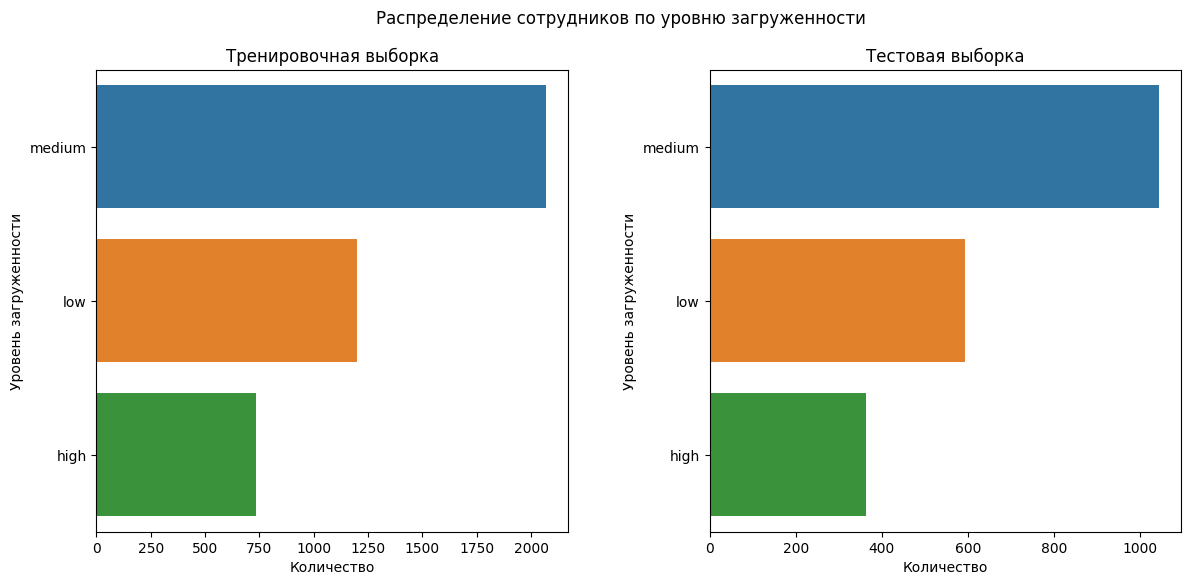

Отношение максимального значения к минимальному в трейне: 2.81
Отношение максимального значения к минимальному в тесте: 2.87


In [15]:
# Построим столбчатую диаграмму распределения сотрудников по уровню загруженности
graphic_cat(
    'workload',
    'Распределение сотрудников по уровню загруженности',
    'Уровень загруженности'
)

Больше всего сотрудников имеют уровень загруженности `medium`. Так, в тренировочной выборке сотрудников с уровнем загруженности `medium` в 2,81 раза больше, чем сотрудников с уровнем загруженности `high`. Распределение имеет некоторое различие. Самой многочисленной группой в обеих выборках является `medium`. А группы `high` и `low` имеют разные веса.

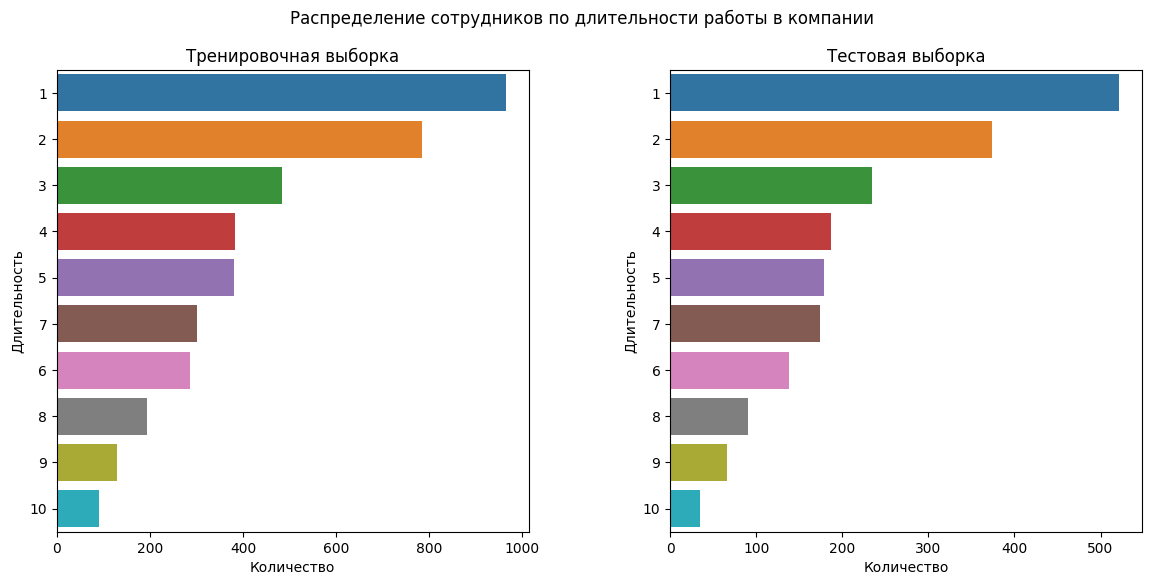

Отношение максимального значения к минимальному в трейне: 10.62
Отношение максимального значения к минимальному в тесте: 14.91


In [16]:
# Построим столбчатую диаграмму распределения сотрудников по длительности работы в компании
graphic_cat(
    'employment_years',
    'Распределение сотрудников по длительности работы в компании',
    'Длительность'
)

Сотрудников, работающих в компании непродолжительное время, гораздо больше, чем сотрудников с большим стажем работы: с увеличением стажа число сотрудников с таким стажем убывает. Распределение похожее в обеих выборках.

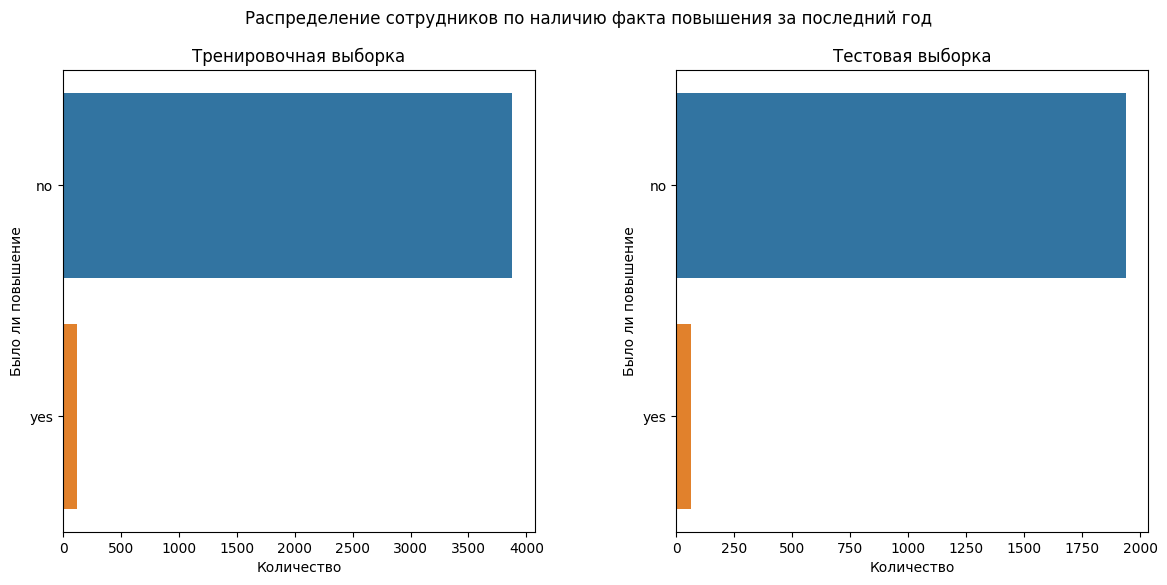

Отношение максимального значения к минимальному в трейне: 32.33
Отношение максимального значения к минимальному в тесте: 30.75


In [17]:
# Построим столбчатую диаграмму распределения сотрудников по наличию факта повышения за последний год
graphic_cat(
    'last_year_promo',
    'Распределение сотрудников по наличию факта повышения за последний год',
    'Было ли повышение'
)

Число сотрудников без повышения более чем в 30 раз больше, чем сотрудников, которых повысили за последний год. Распределение в обеих выборках одинаковое

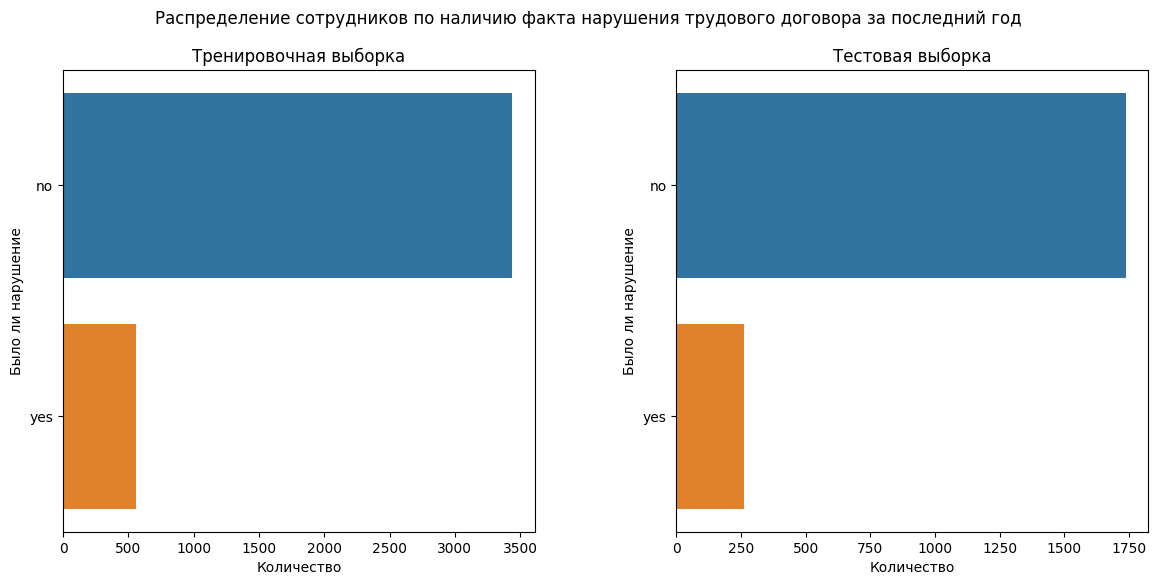

Отношение максимального значения к минимальному в трейне: 6.16
Отношение максимального значения к минимальному в тесте: 6.63


In [18]:
# Построим столбчатую диаграмму распределения сотрудников
# по наличию факта нарушения трудового договора за последний год
graphic_cat(
    'last_year_violations',
    'Распределение сотрудников по наличию факта нарушения трудового договора за последний год',
    'Было ли нарушение'
)

Число сотрудников без нарушений трудового договора более чем в 6 раз больше числа сотрудников, у которых было нарушение трудового договора за последний год. Распределение одинаковое.

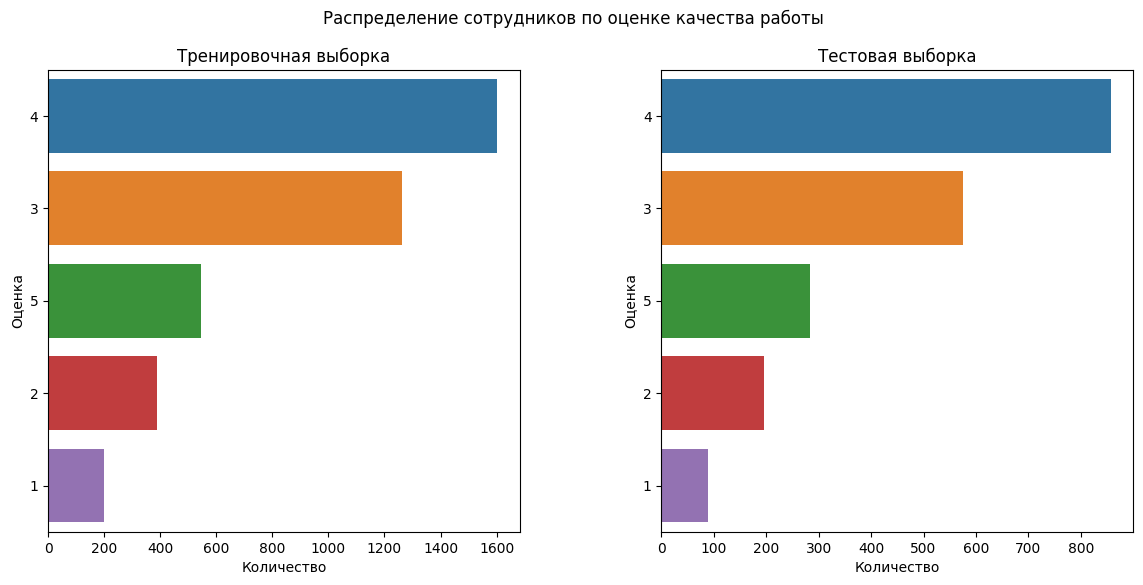

Отношение максимального значения к минимальному в трейне: 7.98
Отношение максимального значения к минимальному в тесте: 9.74


In [19]:
# Построим графики распределения сотрудников по оценке качества работы руководителем
graphic_cat(
    'supervisor_evaluation',
    'Распределение сотрудников по оценке качества работы',
    'Оценка'
)

`3` и `4` - самые популярные оценки. Сотрудников с оценкой `4` в 8-10 раз больше, чем сотрудников с оценкой `1`. Распределение одинаковое.

In [20]:
# Напишем функцию построения графиков для количественных признаков

# функция принимает на вход признак, название графика
def graphics_num(characteristic, graphic_name):
    # строим гистограмму распределения
    plt.title(graphic_name)
    sns.histplot(data=train_data, x=characteristic, color='blue', alpha=0.5, label='train')
    sns.histplot(data=test_data, x=characteristic, color='red', alpha=0.5, label='test')
    plt.legend()
    plt.show()
    # строим два 'ящика с усами' для трейна и для теста
    fig, axes = plt.subplots(nrows=1, ncols=2)
    sns.boxplot(data=train_data, y=characteristic, color='blue', ax=axes[0])
    axes[0].set_title('Разброс значений признаков train')
    sns.boxplot(data=test_data, y=characteristic, color='red', ax=axes[1])
    axes[1].set_title('Разброс значений признаков test')
    plt.subplots_adjust(wspace=1)
    plt.show()

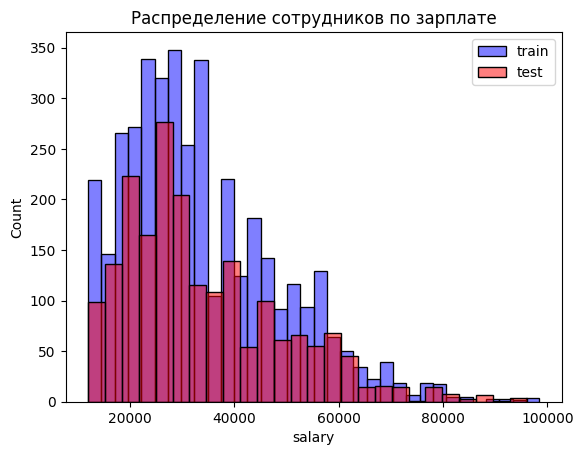

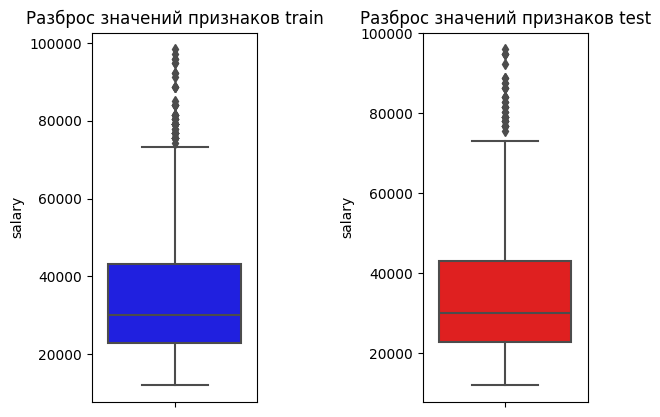

In [21]:
# Построим графики распределения сотрудников по зарплате для трейна
graphics_num(
    'salary', 
    'Распределение сотрудников по зарплате'
)

Медианная зарплата составляет около 30000. Самое большое число сотрудников имеет невысокую зарплату - до 40 с небольшим тысяч. Зарплаты выше 70000 выглядят как выбросы. Но это, по всей видимости, зарплаты сотрудников с высоким уровнем занимаемой должности, которых немного. Распределение в трейне и тесте похожее.

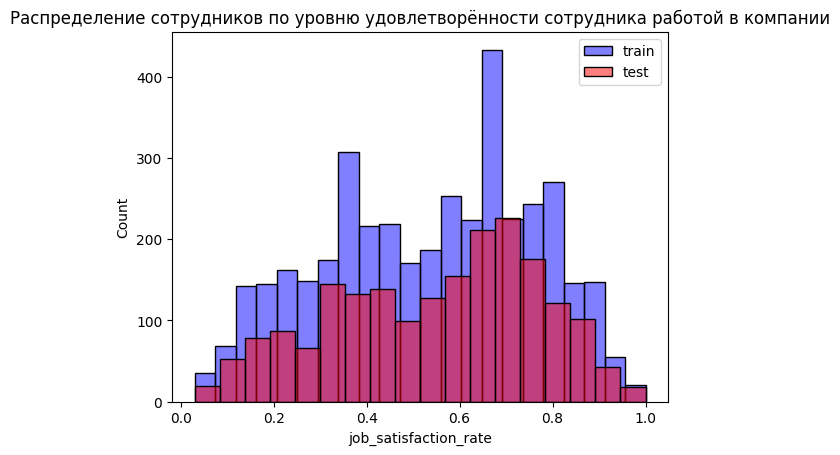

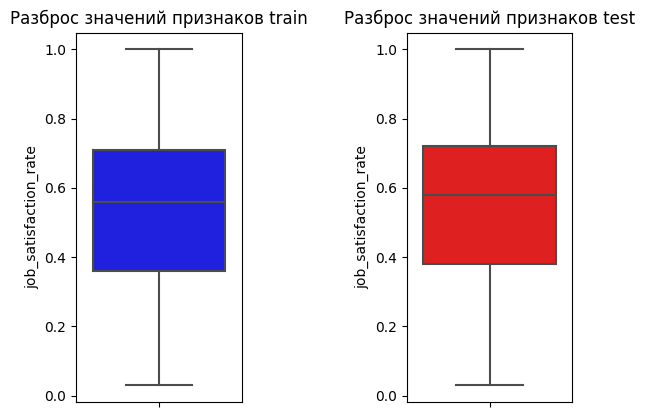

In [22]:
# Построим графики распределения сотрудников по уровню удовлетворённости сотрудника работой в компании для трейна
graphics_num(
    'job_satisfaction_rate', 
    'Распределение сотрудников по уровню удовлетворённости сотрудника работой в компании'
)

Половина сотрудников имеет уровень удовлетворённости работой примерно от 0,4 до 0,7. Медианное значение - около 0,55-0,6. Крайних значений, близких к нулю или близких к единице не так много. Распределение в трейне и тесте похожее.  

Так как мы не сами занимались разделением данных на выборки, мы должны были убедиться, что в данных нет существенных различий в части распределений признаков. Действительно, признаки распределены примерно одинаково в тренировочной и тестовой выборках, следовательно, оценка модели, полученная на `test` выборке, будет корректной.

Большинство признаков в данных категориальные, из числовых признаков только два непрерывных, а два дискретных. Для исследования корреляции лучше всего подходит матрица `phik` - она анализирует корреляцию между признаками любого типа и не требует предварительного кодирования. Важно только правильно настроить параметр `interval_cols`.

In [23]:
# Построим матрицу корреляции `phik`

# Создадим список с наименованиями непрерывных признаков
interval_cols = ['salary', 'job_satisfaction_rate']

# Cчитаем корреляции
phik_overview_1 = train_data.phik_matrix(interval_cols=interval_cols)
phik_overview_2 = test_data.phik_matrix(interval_cols=interval_cols)
print(phik_overview_1.shape)
print(phik_overview_2.shape)

(9, 9)
(9, 9)


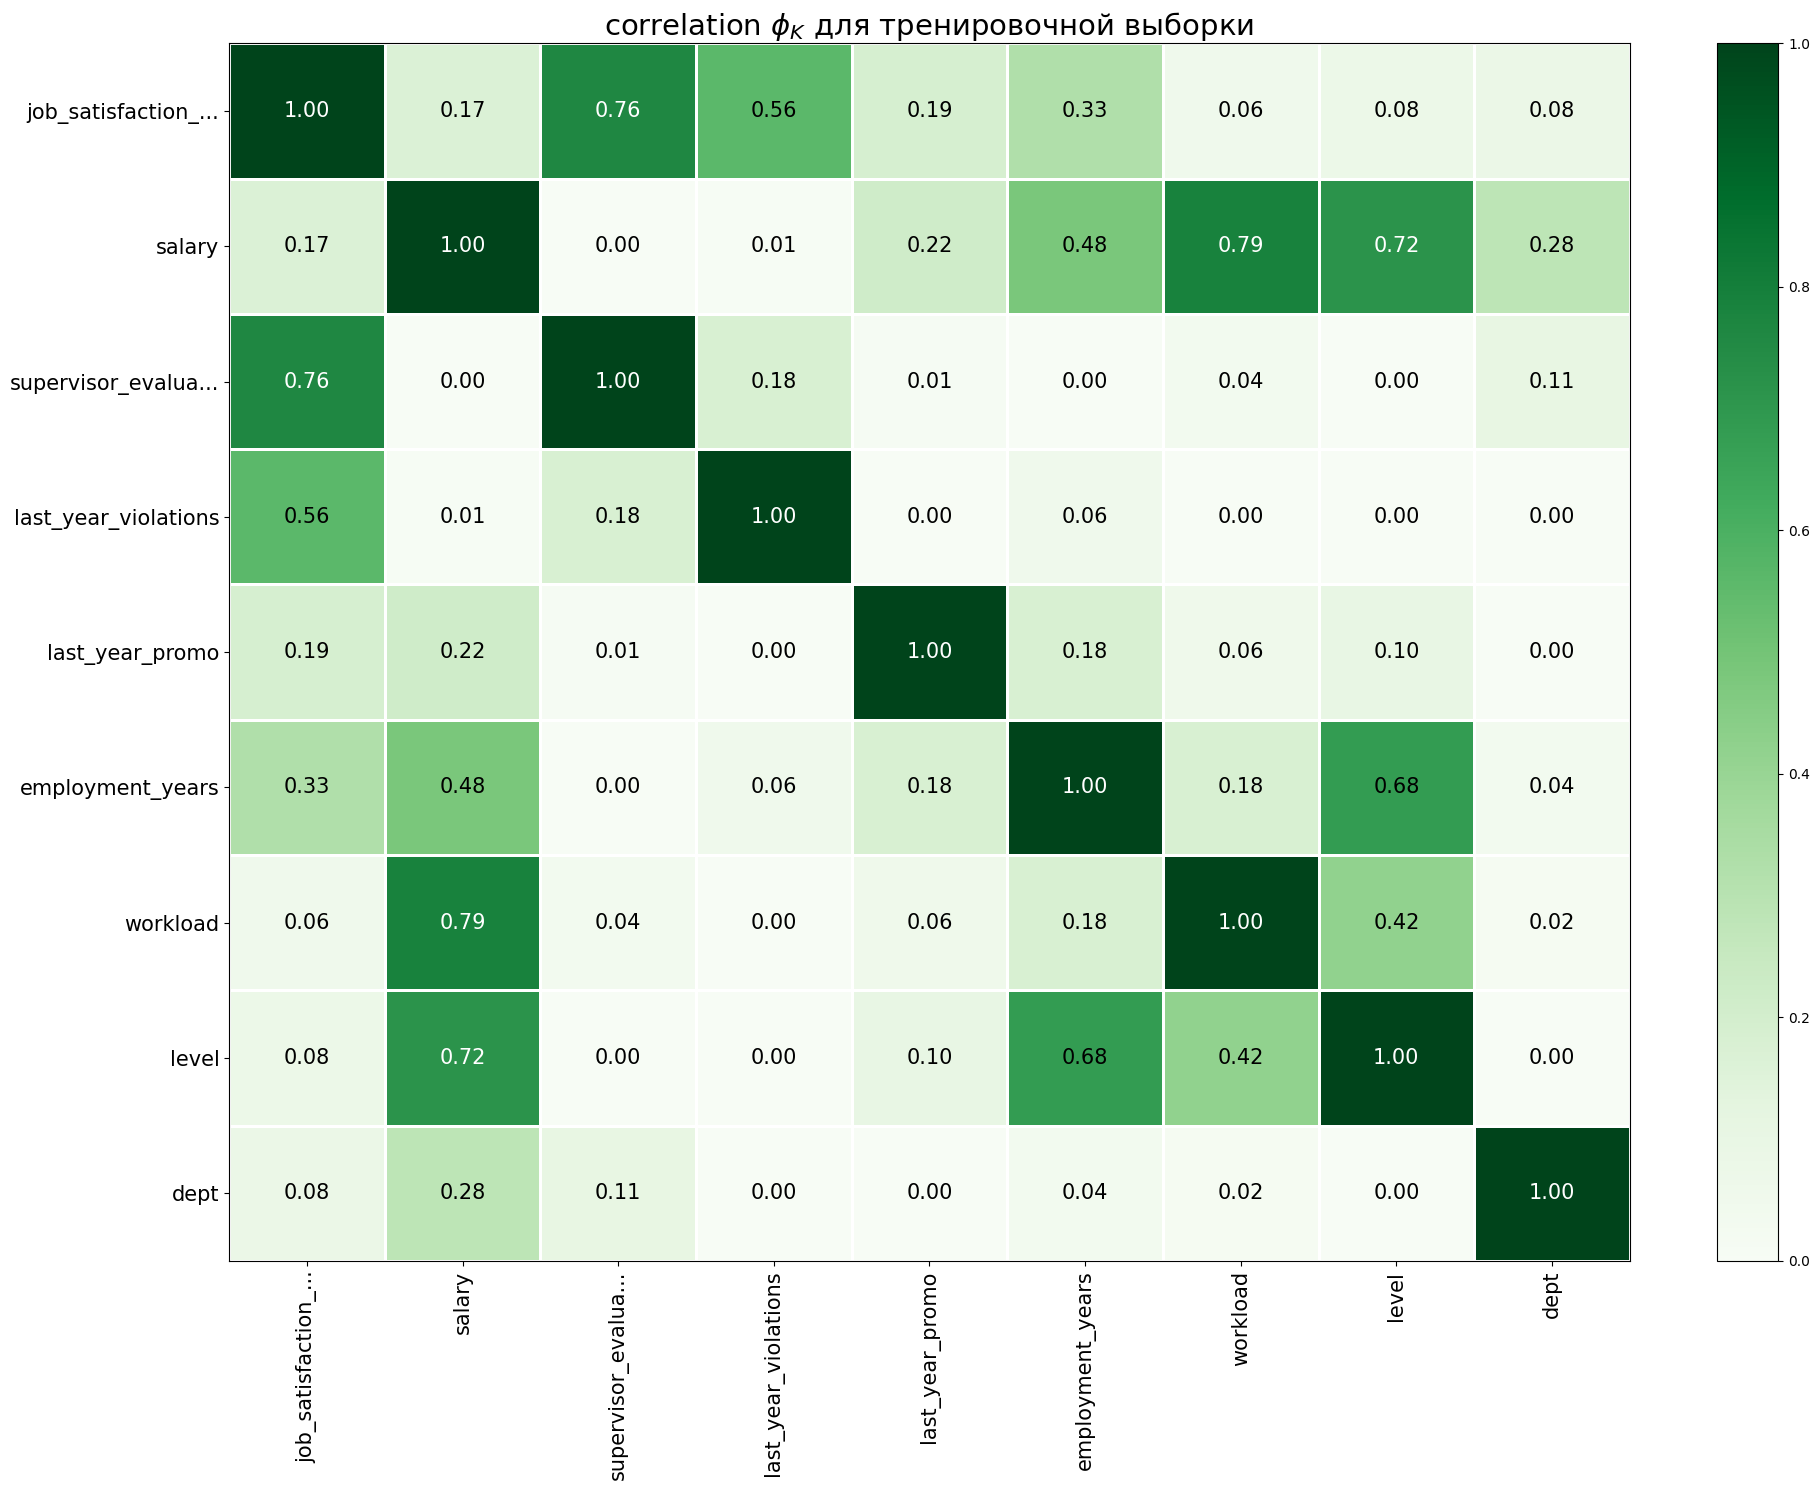

In [24]:
# Построим матрицу `phik` для тренировочной выборки
plot_correlation_matrix(
    phik_overview_1.values,
    x_labels=phik_overview_1.columns,
    y_labels=phik_overview_1.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ для тренировочной выборки',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

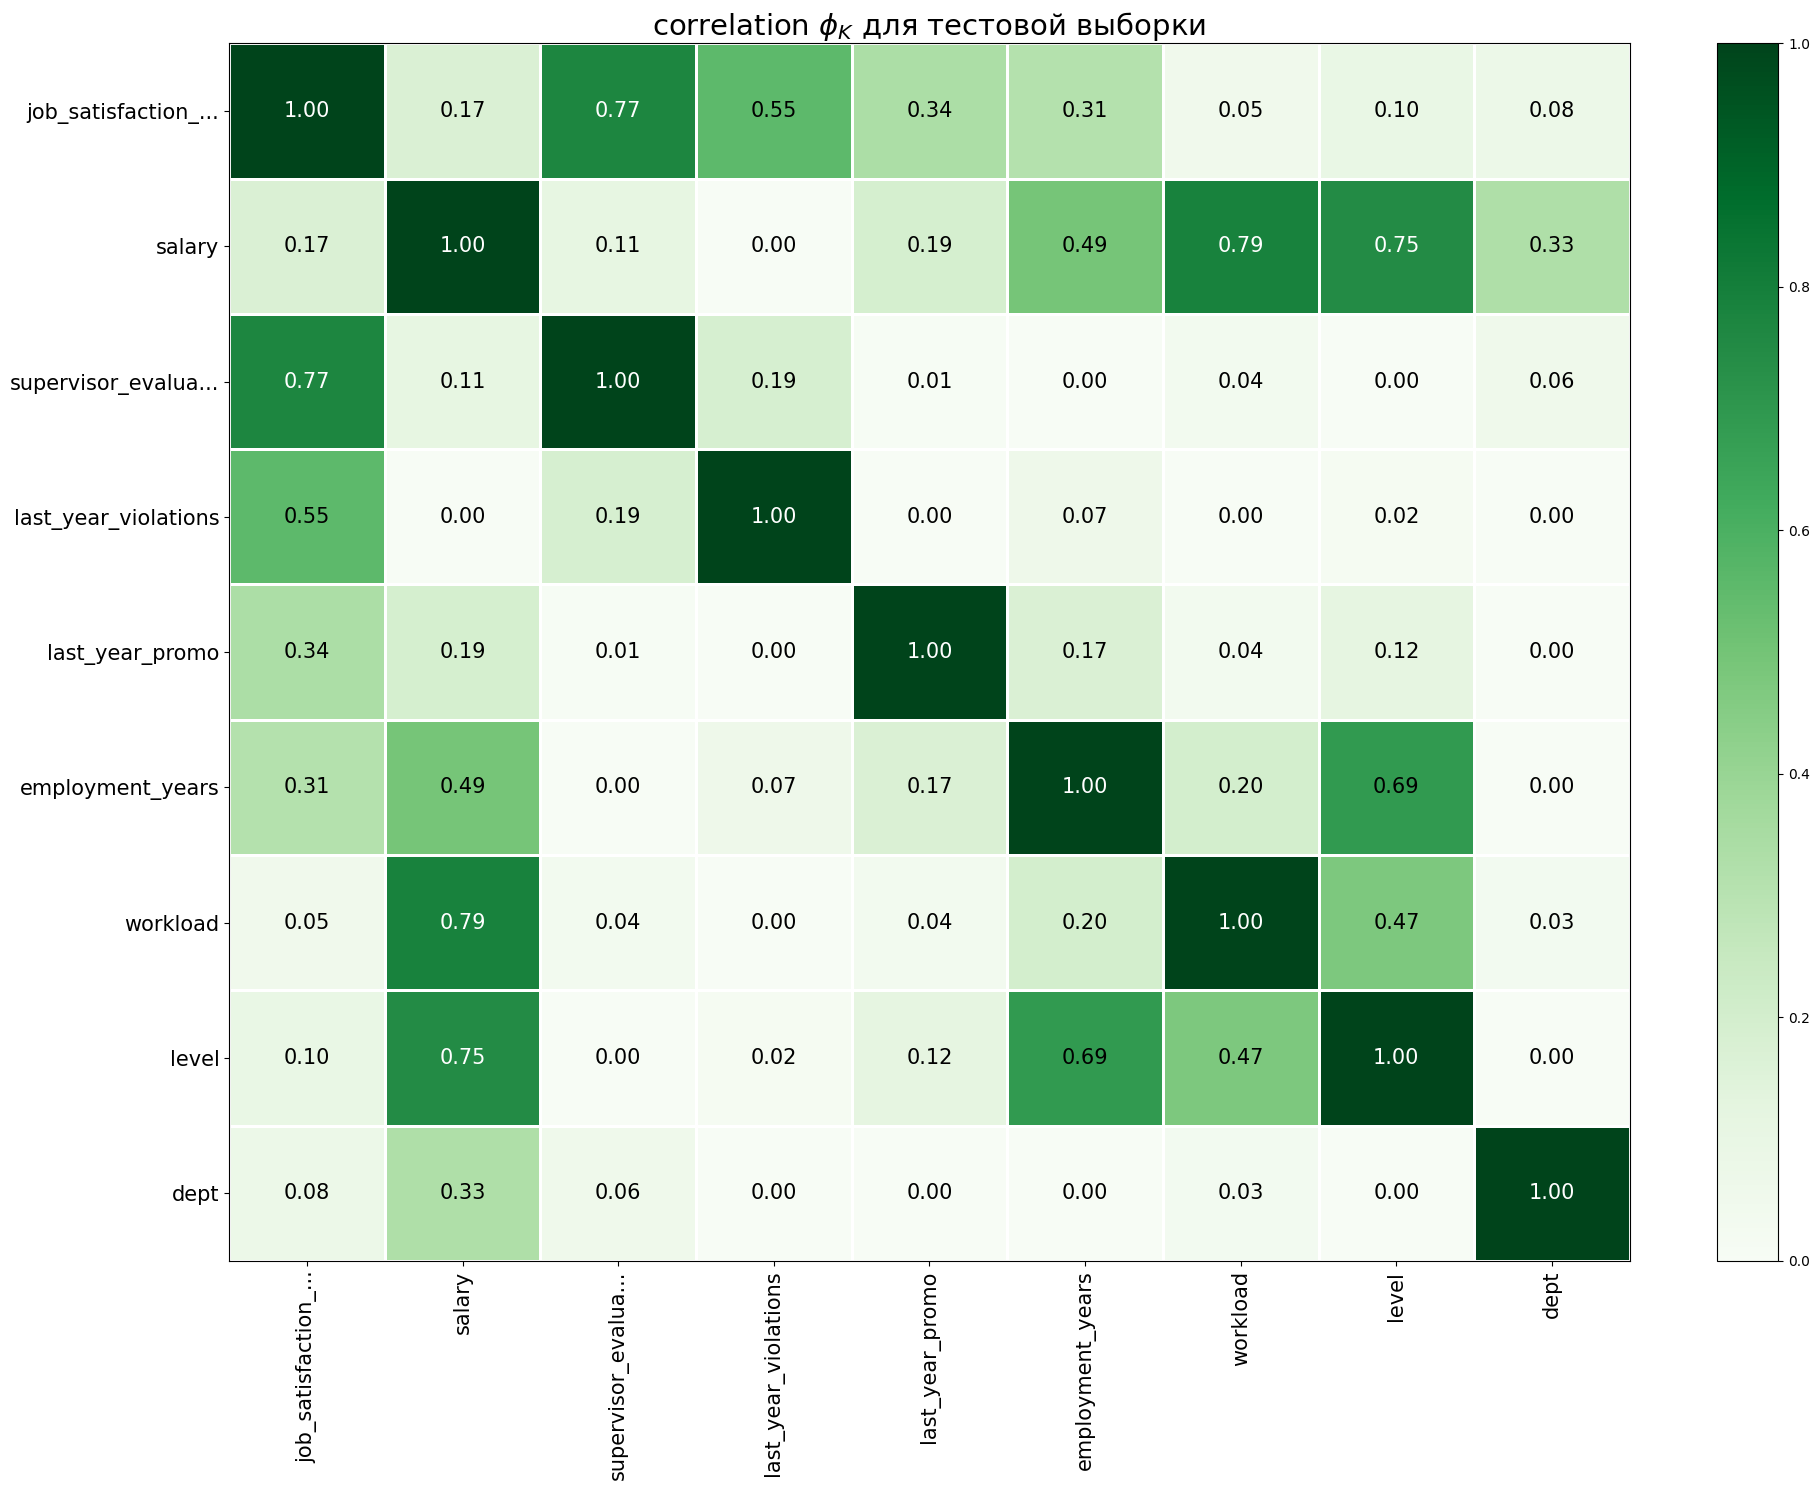

In [25]:
# Построим матрицу `phik` для тестовой выборки
plot_correlation_matrix(
    phik_overview_2.values,
    x_labels=phik_overview_2.columns,
    y_labels=phik_overview_2.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$ для тестовой выборки',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Матрицы `phik` для тренировочной и для тестовой выборок похожи. Самая сильная корреляция отмечается между признаками `worlload` и `salary` (коэффициент `phi_k` 0,79). Сильная корреляция отмечается также между признаками `supervisor_evaluation` и `job_satisfaction_rate` (коэффициент 0,76-0,77), а также `level` и `salary` (коэффициент 0,72-0,75).

In [26]:
# Проверим мультиколлинеарность всех признаков с помощью VIF

# Составим расчётную матрицу для модели, используя `job_satisfaction_rate` в качестве таргета
y, X = dmatrices(
    'job_satisfaction_rate ~ dept+level+workload+employment_years+last_year_promo+\
    last_year_violations+supervisor_evaluation+salary',
    data=train_data,
    return_type='dataframe'
)
# Вычислим VIF для каждой независимой переменной
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

# Выведем на экран значения VIF для каждой независимой переменной
vif

,VIF,variable
0,105.758739,Intercept
1,1.913190,dept[T.marketing]
2,1.988885,dept[T.purchasing]
3,2.723308,dept[T.sales]
4,2.499107,dept[T.technology]
5,3.949836,level[T.middle]
6,4.752623,level[T.senior]
7,9.891034,workload[T.low]
8,4.660330,workload[T.medium]
9,1.043980,last_year_promo[T.yes]


In [27]:
# Проверим мультиколлинеарность всех, а не только количественных, признаков с помощью VIF
# Составим расчётную матрицу для модели, используя `job_satisfaction_rate` в качестве таргета
y, X = dmatrices(
    'job_satisfaction_rate ~ dept+level+workload+employment_years+last_year_promo+\
    last_year_violations+supervisor_evaluation+salary',
    data=test_data,
    return_type='dataframe'
)
# Вычислим VIF для каждой независимой переменной
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

# Выведем на экран значения VIF для каждой независимой переменной
vif

,VIF,variable
0,109.591927,Intercept
1,1.931591,dept[T.marketing]
2,1.917760,dept[T.purchasing]
3,2.748489,dept[T.sales]
4,2.581700,dept[T.technology]
5,4.091310,level[T.middle]
6,5.387943,level[T.senior]
7,10.253578,workload[T.low]
8,5.013664,workload[T.medium]
9,1.055871,last_year_promo[T.yes]


Таблицы VIF для тренировочной и тестовой выборки примерно похожи.  
Рассмотрим более подробро тренировочную выборку. Значения VIF для признаков `workload[T.low]` и `salary` очень велики, это указывает на потенциально сильную корреляцию этих признаков с другими. То есть присутствует мультиколлинеарность.  
Попробуем посчитать VIF, убрав признак `workload`.

In [28]:
# Проверим мультиколлинеарность с помощью VIF
# Составим расчётную матрицу для модели, используя `job_satisfaction_rate` в качестве таргета
y, X = dmatrices(
    'job_satisfaction_rate ~ dept+level+employment_years+last_year_promo+\
    last_year_violations+supervisor_evaluation+salary',
    data=train_data,
    return_type='dataframe'
)
# Вычислим VIF для каждой независимой переменной
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

# Выведем на экран значения VIF для каждой независимой переменной
vif

,VIF,variable
0,28.680584,Intercept
1,1.904516,dept[T.marketing]
2,1.980919,dept[T.purchasing]
3,2.687501,dept[T.sales]
4,2.320523,dept[T.technology]
5,2.454986,level[T.middle]
6,2.399882,level[T.senior]
7,1.043476,last_year_promo[T.yes]
8,1.049141,last_year_violations[T.yes]
9,1.928958,employment_years


Теперь все значения VIF небольшие. Мультиколлинеарность исключена. Значит, действительно, при построении модели признак `workload` брать не нужно.

Итак, мы убедились, что в данных тренировочной и тестовой выборок нет существенных различий в части распределений признаков, следовательно, оценка модели, полученная на тестовой выборке, будет корректной.  

Признаки `employment_years`, `salary`, `supervisor_evaluation` - количественные, их будем масштабировать.  
Признаки `last_year_promo`, `last_year_violations` - категориальные номинальные бинарные, их будем кодировать с помощью `OneHotEncoder`.  
Признаки `dept`, `level` - категориальные ранговые, их будем кодировать с помощью `OrdinalEncoder`, там же обработаем пропущенные значения.  
Признак `workload` не берём в моделирование.  
В данном случае, когда целевой признак принимает непрерывное количественное значение, то есть стоит задача регрессии, дисбаланс классов не является проблемой.

### Подготовка данных
После перевода `id` в индексы нужно проверить тренировочную выборку на наличие явных дубликатов. Они не представляют ценности для моделирования. Тестовую выборку не трогаем.

In [29]:
train_data.duplicated().sum()

245

После перевода id в индексы появились явные дубликаты. Удалим их.

In [30]:
train_data = train_data.drop_duplicates()
train_data.shape

(3755, 9)

В таблице с данными осталось 3755 строк.  
Разделим тренировочную и тестовую выборку на входные и целевой признак.  
Дополним пайплайн шага предобработки из п. 1.2 шагами по подготовке признаков.

In [31]:
# Зададим константу
RANDOM_STATE = 42

# Разделим тренировочную выборку на входные и целевой признаки
X_train = train_data.drop(['job_satisfaction_rate', 'workload'], axis=1)
y_train = train_data['job_satisfaction_rate']

# Разделим тестовую выборку на входные и целевой признаки
X_test = test_data.drop(['job_satisfaction_rate', 'workload'], axis=1)
y_test = test_data['job_satisfaction_rate']

In [32]:
# Обозначим типы исходных данных
ohe_columns = ['last_year_promo', 'last_year_violations']
ord_columns = ['dept', 'level']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# Добавляем OHE-кодирование в пайплайн
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )      
    ]
)

In [33]:
# Добавляем Ordinal-кодирование в пайплайн
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['sales', 'hr', 'technology', 'purchasing', 'marketing'],
                    ['junior', 'middle', 'senior']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# Объединяем операции по подготовке данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

### Обучение моделей
Обучим две модели. Одну из них возьмём `LinearRegression()`, а другую - `DecisionTreeRegressor()`. Подберём гиперпараметры для модели `DecisionTreeRegressor()` с помощью `GridSearchCV`. Выберем лучшую модель и проверим её качество на основе пользовательской метрики - `SMAPE`.

In [34]:
# Напишем функцию для расчёта пользовательской метрики
def smape_func(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(numerator / denumerator) * 100

# Создаём пользовательский скоринг для кросс-валидации, указываем, что чем модель качественнее, тем ниже метрика
smape_score = make_scorer(smape_func, greater_is_better=False)

In [35]:
# Создаём итоговый пайплайн, присоединяем шаг с моделированием,
# используем модель DecisionTreeRegressor
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [36]:
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strate...
                                                                                               'hr',
                                                                                               'technology',
                                                                                               'purchasing',
                                                                                               'marketing'],
                                                                                              ['junior',
                                                                                               'middle',
                                                                                               'senior']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['dept', 'level']),
                                                 ('num', StandardScaler(),
                                                  ['employment_years',
                                                   'supervisor_evaluation',
                                                   'salary'])])),
                ('models', DecisionTreeRegressor(random_state=42))])

In [37]:
# Включаем в обучение две модел и подбираем гиперпараметры для каждой модели
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(2, 11),
        'models__max_leaf_nodes': range(100, 200),
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [38]:
# Перебираем варианты для каждой модели
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring=smape_score, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [39]:
%%time
randomized_search.fit(X_train, y_train)

CPU times: total: 250 ms
Wall time: 872 ms


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_bef...
                                         'models__max_leaf_nodes': range(100, 200),
                                         'models__min_samples_leaf': range(2, 11),
                                         'models__min_samples_split': range(2, 11),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape_func, greater_is_better=False, response_method='predict'))

In [40]:
print('Метрика SMAPE на кросс-валидации:', round(-randomized_search.best_score_, 2))
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика SMAPE на кросс-валидации: 19.29
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
   

Получили недостаточно хорошее значение метрики SMAPE. Попробуем изменить некоторые гиперпараметры.

In [41]:
# Изменяем гиперпараметры для каждой модели
param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(2, 11),
        'models__max_leaf_nodes': range(100, 300),
        'models__max_depth': [None] + [i for i in range(2, 15)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

# Перебираем варианты для каждой модели
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring=smape_score, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [42]:
%%time
randomized_search.fit(X_train, y_train)

CPU times: total: 250 ms
Wall time: 524 ms


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_bef...
                                         'models__max_leaf_nodes': range(100, 300),
                                         'models__min_samples_leaf': range(2, 11),
                                         'models__min_samples_split': range(2, 11),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape_func, greater_is_better=False, response_method='predict'))

In [43]:
print('Метрика SMAPE на кросс-валидации:', round(-randomized_search.best_score_, 2))
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика SMAPE на кросс-валидации: 16.75
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
   

In [44]:
# Получение лучшей модели
best_model = randomized_search.best_estimator_

# Получим прогноз целевого признака по тестовой выборке, используем лучшую модель
y_pred = best_model.predict(X_test)

print(f'Метрика SMAPE на тестовой выборке: {round(smape_func(y_test, y_pred), 2)}')

Метрика SMAPE на тестовой выборке: 14.94


Проверим полученную модель на адекватность с помощью Dummy модели.

In [45]:
# Получение преобразователя из pipeline
data_preprocessor = best_model.named_steps['preprocessor']

# Применение преобразований к X_train и к X_test
X_train_transformed = data_preprocessor.transform(X_train)
X_test_transformed = data_preprocessor.transform(X_test)

In [46]:
# Создадим и обучим модель DummyRegressor
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

# Предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# Оценка качества модели по SMAPE
dummy_smape = smape_func(y_test, dummy_model_preds)
print('Метрика SMAPE для Dummy модели =', round(dummy_smape, 2)) 

Метрика SMAPE для Dummy модели = 38.26


Результат тестирования нашей модели на тестовой выборке гораздо лучше, чем результат тестирования константной модели. Это означает, что наша модель адекватна.

In [47]:
# Добавим столбец с предсказаниями в датафрейм с тестовыми данными
predict_data = test_data.copy()
predict_data['pred_satisfaction'] = y_pred
predict_data.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,pred_satisfaction
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,0.847857
686555,hr,junior,medium,1,no,no,4,30000,0.72,0.668235
467458,sales,middle,low,5,no,no,4,19200,0.64,0.728571
418655,sales,middle,low,6,no,no,4,19200,0.60,0.669130
789145,hr,middle,medium,5,no,no,5,40800,0.75,0.777000


**Вывод.** Построены пайплайны, которые перебирают три метода масштабирования, две модели и гиперпараметры моделей. В итоге выбрана лучшая модель `DecisionTreeRegressor()` с  методом масштабирования `MinMaxScaler()` и следующими гиперпараметрами: `max_depth=14`, `max_leaf_nodes=261`, `min_samples_leaf=10`, `min_samples_split=7`. Значение метрики `SMAPE` на тренировочной выборке 16,75. Значение метрики отрицательное, потому что мы указали, что при улучшении модели метрика должна уменьшаться, и `make_scorer` менет знак значения `smape_func` на противоположный. При выводе на экран значения метрики мы подставили знак минус, чтобы значение метрики выглядело корректно. Время перебора моделей и гиперпараметров составило полсекунды.

При прогнозировании с помощью лучшей модели на тестовой выборке получено значение метрики `SMAPE` 14,94.

## Предсказание увольнения сотрудника из компании
### Загрузка данных

In [48]:
# Загрузим тренировочную выборку, сохраним её в датафрейм `train_quit`
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    
# Изучим общую информацию о датафрейме `train_quit`
information(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

In [49]:
train_quit.to_csv('train_quit.csv')

In [50]:
# Данные с входными признаки тестовой выборки уже загружены в фал `test_features`
# Напомним общую информацию о датафрейме `test_features`
information(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

In [51]:
# Загрузим целевой признак тестовой выборки, сохраним её в датафрейм `test_target_quit`
try:
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')
    
# Изучим общую информацию о датафрейме `test_target_quit`
information(test_target_quit)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

In [52]:
test_target_quit.to_csv('test_target_quit.csv')

Итак, данные для задачи 2 загружены.

### Предобработка данных
Данные содержатся в трёх датафреймах, отдельно тренировочная выборка, отдельно входные признаки тестовой выборки и отдельно целевой признак тестовой выборки.
В тренировочной выборке 4000 строк и 10 столбцов. В тестовой выборке 2000 строк, таблица с входными признаками содержит 9 столбцов, с целевым признаком - 2 столбца.
Объединим два тестовых датафрейма в один датафрейм test_data_quit.

In [53]:
test_quit = test_features.merge(test_target_quit, on='id')
information(test_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB


None

In [54]:
# Создаём словарь датафреймов `dfs_quit`
dfs_quit = {
    'train_quit': train_quit,
    'test_quit': test_quit
}

# Создаём цикл для проверки на наличие пропусков, явных и неявных дубликатов в датафреймах из словаря `dfs_quit`
for name, df in dfs_quit.items():
    print(f'Название датафрейма: {name}\n')
    print(f'Количество пропусков\n{df.isna().sum()}\n')
    print(f'Количество дубликатов {df.duplicated().sum()}\n')
    print('Уникальные значения в категориальных столбцах:')
    df_cat = df.select_dtypes(include=['object'])
    for column in df_cat.columns:
        print(f'столбец "{column}": {df_cat[column].unique()}')
    print('-' * 40)

Название датафрейма: train_quit

Количество пропусков
id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Количество дубликатов 0

Уникальные значения в категориальных столбцах:
столбец "dept": ['sales' 'purchasing' 'marketing' 'technology' 'hr']
столбец "level": ['middle' 'junior' 'sinior']
столбец "workload": ['high' 'medium' 'low']
столбец "last_year_promo": ['no' 'yes']
столбец "last_year_violations": ['no' 'yes']
столбец "quit": ['no' 'yes']
----------------------------------------
Название датафрейма: test_quit

Количество пропусков
id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary 

In [55]:
# Заменим пробелы на nan методом replace()
test_quit['dept'] = test_quit['dept'].replace(' ', np.nan, regex= True)
test_quit['workload'] = test_quit['workload'].replace(' ', np.nan, regex= True)

# Исправим грамматическую ошибку
train_quit['level'] = train_quit['level'].replace('sinior', 'senior', regex= True)
test_quit['level'] = test_quit['level'].replace('sinior', 'senior', regex= True)

# Проверим
print("Уникальные значения в столбце 'dept'", test_quit['dept'].unique())
print("Уникальные значения в столбце 'workload'", test_quit['workload'].unique())
print("Уникальные значения в столбце 'level' таблицы 'train_quit'", train_quit['level'].unique())
print("Уникальные значения в столбце 'level' таблицы 'test_quit'", test_quit['level'].unique())

Уникальные значения в столбце 'dept' ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
Уникальные значения в столбце 'workload' ['medium' 'low' 'high' nan]
Уникальные значения в столбце 'level' таблицы 'train_quit' ['middle' 'junior' 'senior']
Уникальные значения в столбце 'level' таблицы 'test_quit' ['junior' 'middle' 'senior' nan]


In [56]:
# Сделаем столбец `id` в каждом датафрейме индексами
train_data_quit = train_quit.set_index('id')
test_data_quit = test_quit.set_index('id')

# Проверим
information(train_data_quit)
information(test_data_quit)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


None

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1997 non-null   object
 1   level                  1999 non-null   object
 2   workload               1999 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
 8   quit                   2000 non-null   object
dtypes: int64(3), object(6)
memory usage: 156.2+ KB


None

Пропуски обработаем в пайплайне после исследовательского анализа данных.

Итак, два датафрейма с тестовыми данными объединили в один, проверили данные на дубликаты. Удалили строки с пробелами. Сделали столбец `id` в каждом датафрейме индексами. Пропуски будут обработаны в пайплайне.

### Исследовательский анализ данных

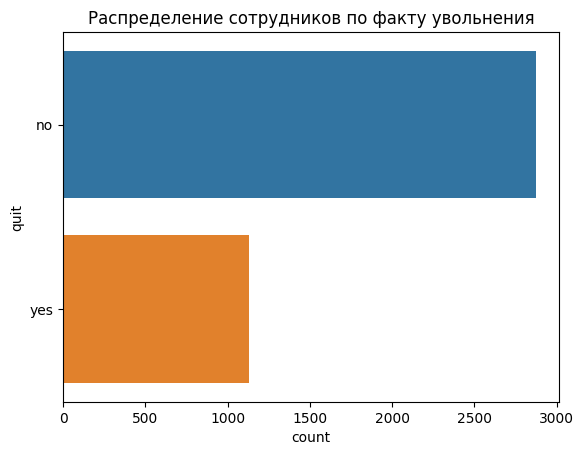

Отношение максимального значения к минимальному в таргете: 2.55


In [57]:
# Прежде всего рассмотрим целевой признак
# построим график распределения целевого признака
sns.countplot(data=train_data_quit, y='quit')
plt.title('Распределение сотрудников по факту увольнения')
plt.show()
# рассчитаем соотношение значений целевого признака в тренировочной выборке
target_balance = (train_data_quit.groupby('quit')['quit'].count().max() /\
train_data_quit.groupby('quit')['quit'].count().min()).round(2)
print(f'Отношение максимального значения к минимальному в таргете: {target_balance}')

Число значений целевого признака отличается в 2,55 раза. Налицо дисбаланс классов.

In [58]:
# Напишем функцию построения столбчатых диаграмм
# для категориальных признаков в разбивке по таргету

# функция принимает на вход признак, название графика, название оси у
def graphic_cat(charakteristic, graphic_name, label_name):
    # строим график
    fig = plt.figure(figsize=(6, 4))
    sns.countplot(data=train_data_quit, y=charakteristic, hue='quit')
    plt.xlabel('Количество')
    plt.ylabel(label_name)
    plt.grid()
    plt.show()
    # выводим на экран соотношение значений признака в разбивке по таргету
    print(train_data_quit.groupby('quit')[charakteristic].value_counts(normalize=True))

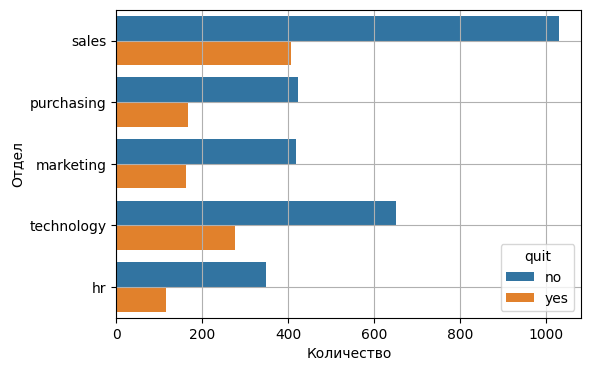

quit  dept      
no    sales         0.358983
      technology    0.227019
      purchasing    0.146936
      marketing     0.145891
      hr            0.121170
yes   sales         0.360816
      technology    0.244681
      purchasing    0.147163
      marketing     0.144504
      hr            0.102837
Name: dept, dtype: float64


In [59]:
# Построим столбчатую диаграмму распределения сотрудников по отделу работы
graphic_cat(
    'dept',
    'Распределение сотрудников по отделам',
    'Отдел'
)

Больше всего уволившихся сотрудников, так же как и оставшихся, работало в отделе `sales` - 36 %.

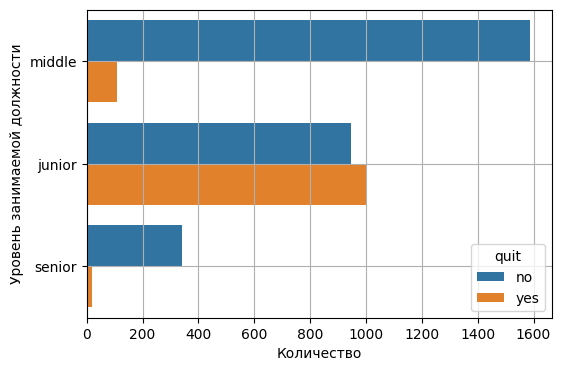

quit  level 
no    middle    0.552228
      junior    0.329387
      senior    0.118384
yes   junior    0.889184
      middle    0.095745
      senior    0.015071
Name: level, dtype: float64


In [60]:
# Построим столбчатую диаграмму распределения сотрудников по уровню занимаемой должности
graphic_cat(
    'level',
    'Распределение сотрудников по уровню занимаемой должности',
    'Уровень занимаемой должности'
)

Подавляющее большинство уволившихся сотрудников имеет уровень занимаемой должности `junior` - 88 %.

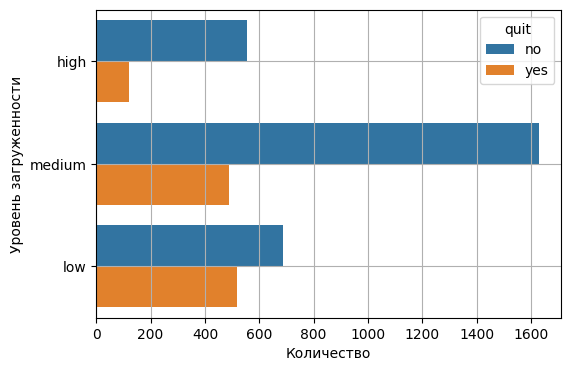

quit  workload
no    medium      0.567549
      low         0.239903
      high        0.192549
yes   low         0.460106
      medium      0.432624
      high        0.107270
Name: workload, dtype: float64


In [61]:
# Построим столбчатую диаграмму распределения сотрудников по уровню загруженности
graphic_cat(
    'workload',
    'Распределение сотрудников по уровню загруженности',
    'Уровень загруженности'
)

Чаще увольняются сотрудники с низким и средним уровнем загруженности, реже - с высоким (всего 10 % от всех уволившихся).

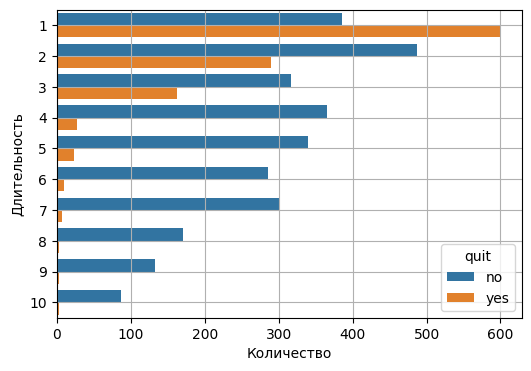

quit  employment_years
no    2                   0.169568
      1                   0.134401
      4                   0.127437
      5                   0.118036
      3                   0.110028
      7                   0.104805
      6                   0.099582
      8                   0.059540
      9                   0.046309
      10                  0.030292
yes   1                   0.531028
      2                   0.257092
      3                   0.144504
      4                   0.023936
      5                   0.020390
      6                   0.008865
      7                   0.006206
      8                   0.002660
      9                   0.002660
      10                  0.002660
Name: employment_years, dtype: float64


In [62]:
# Построим столбчатую диаграмму распределения сотрудников по длительности работы в компании
graphic_cat(
    'employment_years',
    'Распределение сотрудников по длительности работы в компании',
    'Длительность'
)

Сотрудники, проработавшие короткое время в компании, увольняются гораздо чаще, чем сотрудники с более длительным стажем работы в данной компании.

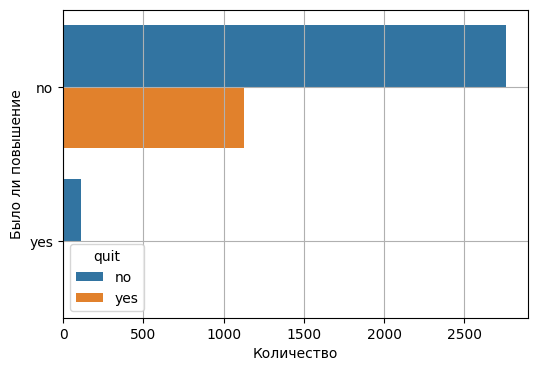

quit  last_year_promo
no    no                 0.961003
      yes                0.038997
yes   no                 0.999113
      yes                0.000887
Name: last_year_promo, dtype: float64


In [63]:
# Построим столбчатую диаграмму распределения сотрудников по наличию факта повышения за последний год
graphic_cat(
    'last_year_promo',
    'Распределение сотрудников по наличию факта повышения за последний год',
    'Было ли повышение'
)

Сотрудники, получившие повышение за последний год, не увольняются. Уволившиеся сотрудники не получали повышения за последний год в 96 % случаев.

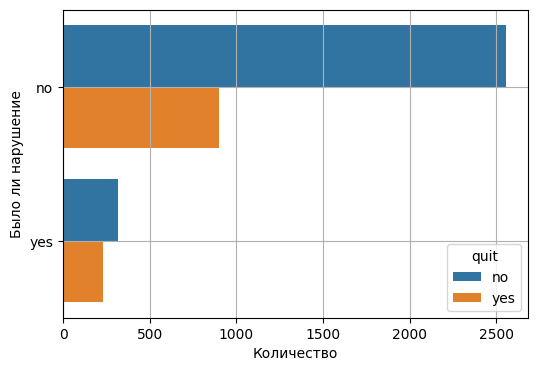

quit  last_year_violations
no    no                      0.889624
      yes                     0.110376
yes   no                      0.797872
      yes                     0.202128
Name: last_year_violations, dtype: float64


In [64]:
# Построим столбчатую диаграмму распределения сотрудников
# по наличию факта нарушения трудового договора за последний год
graphic_cat(
    'last_year_violations',
    'Распределение сотрудников по наличию факта нарушения трудового договора за последний год',
    'Было ли нарушение'
)

Среди нарушивших трудовой договор за последний год уволившихся и оставшихся почти поровну, среди не нарушавших трудовой договор оставшихся значительно больше. В целом среди уволившихся не нарушавших трудовой договор больше, чем нарушавших (80 %).

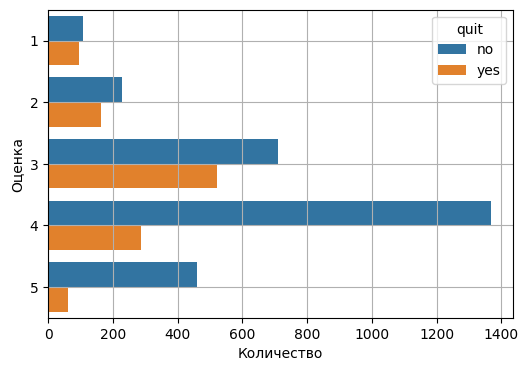

quit  supervisor_evaluation
no    4                        0.476323
      3                        0.247214
      5                        0.160167
      2                        0.079039
      1                        0.037256
yes   3                        0.463652
      4                        0.253546
      2                        0.145390
      1                        0.084220
      5                        0.053191
Name: supervisor_evaluation, dtype: float64


In [65]:
# Построим столбчатую диаграмму распределения сотрудников
# по оценке качества работы сотрудника, которую дал руководитель
graphic_cat(
    'supervisor_evaluation',
    'Распределение сотрудников по оценке качества работы руководителем',
    'Оценка'
)

Уволившиеся сотрудники чаще всего имели оценку качества работы руководителем `3` (46 %), а оставшиеся - `4` (48 %).

In [66]:
# Напишем функцию построения графиков для количественных признаков

# функция принимает на вход датафрейм, признак, название графика
def graphics_num(data, characteristic, feature_title):
    # задаём общую схему графика
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    fig.suptitle(feature_title)
    # строим нормированную гистограмму распределения (нивелируем разницу в размерах выборок),
    # по оси у будет плотность распределения
    sns.histplot(data=data, x=characteristic, hue='quit', ax=axes[0], stat='density', common_norm=False)
    axes[0].set_title('Гистограмма распределения')
    # строим 'ящики с усами' в разбивке по таргету
    sns.boxplot(data=data, x='quit', y=characteristic, ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    plt.show()

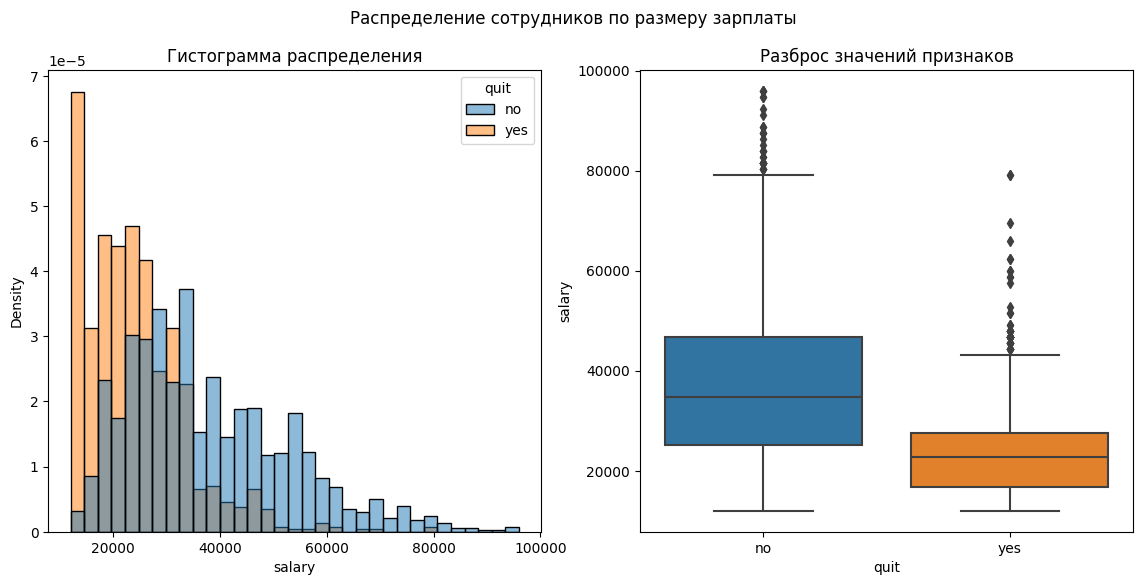

In [67]:
# Построим графики распределения сотрудников по размеру зарплаты
graphics_num(
    train_data_quit,
    'salary',
    'Распределение сотрудников по размеру зарплаты'
)

In [68]:
# Рассчитаем медианное значение зарплаты для оставшихся и уволившихся сотрудников отдельно
train_data_quit.groupby('quit')['salary'].median()

quit
no     34800
yes    22800
Name: salary, dtype: int64

In [69]:
# Выведем числовое описание распределения уволившихся работников по зарплате
train_data_quit.query('quit == "yes"')['salary'].describe()

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

Уволившиеся сотрудники чаще имели более низкую зарплату, чем оставшиеся сотрудники. Медианная зарплата уволившихся сотрудников составила 22800, оставшихся - 34800. Половина уволившихся сотрудников имела зарплату от 16800 до 27600.

In [70]:
# Добавим признак `job_satisfaction_rate` в тестовую выборку
test_data_quit_sat = test_data_quit.join(test_data['job_satisfaction_rate'])
test_data_quit_sat.sample(10)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
417411,sales,junior,low,2,no,no,4,12000,yes,0.63
392999,purchasing,junior,high,2,no,no,4,39600,no,0.80
887670,sales,middle,medium,7,no,no,3,38400,no,0.49
460518,purchasing,junior,medium,2,no,no,1,21600,yes,0.36
857722,sales,middle,low,4,no,no,3,27600,no,0.39
959371,technology,middle,medium,7,no,no,4,40800,no,0.62
313659,sales,junior,low,4,no,yes,3,14400,yes,0.24
102102,marketing,junior,medium,3,no,no,4,25200,no,0.73
998548,marketing,junior,medium,2,no,no,4,32400,yes,0.76


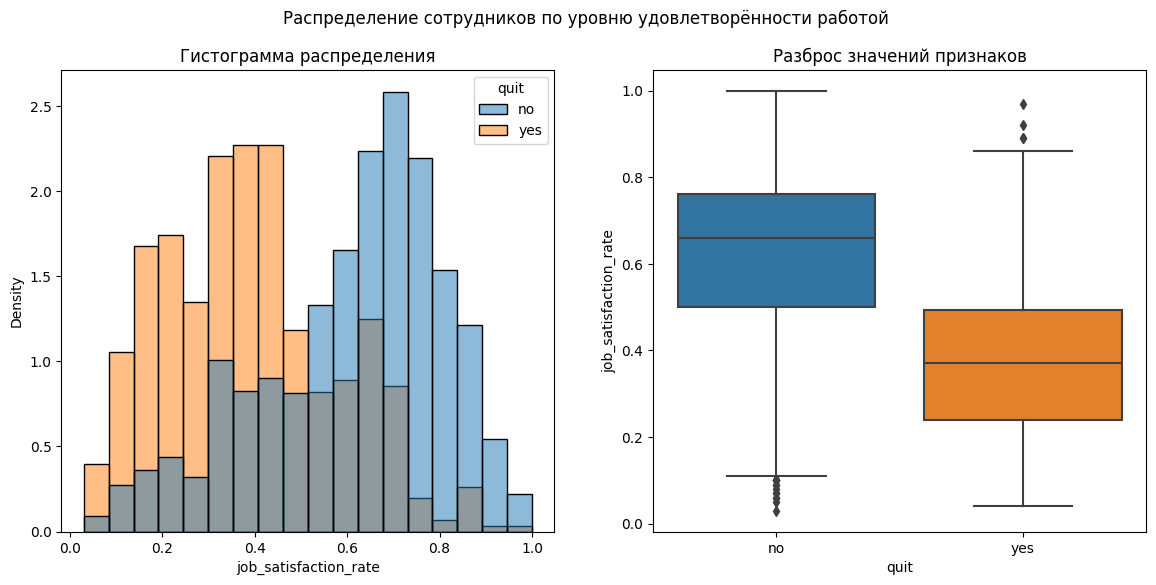

In [71]:
# Построим график распределения сотрудников по удовлетворённости работой
# в разбивке по уволившимся и оставшимся сотрудникам
graphics_num(
    test_data_quit_sat,
    'job_satisfaction_rate',
    'Распределение сотрудников по уровню удовлетворённости работой'
)

Уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Среди уволившихся удовлетворённость работой значительно ниже, чем среди оставшихся: распределение на графике имеет у уволившихся правостороннюю асимметрию, а у оставшихся - левостороннюю. Медианное значение удовлетворённости у уволившихся менее 0,4, а у оставшихся - более 0,65.

Разберёмся, действительно ли среди уволившихся сотрудников удовлетворённость работой меньше.  
Сформулируем нулевую гипотезу: Н<sub>0</sub>: средняя удовлетворённость работой уволившихся сотрудников равна средней удовлетворённости работой оставшихся сотрудников.  Альтернативная гипотеза Н<sub>1</sub>: средняя удовлетворённость уволившихся сотрудников меньше средней удовлетворённости оставшихся сотрудников.

Для анализа используем данные столбца `job_satisfaction_rate` из датафреймa `train_data_quit_sat`.

In [72]:
# Имеются две выборки, взятые независимо друг от друга из двух генеральных совокупностей
satisfaction_quit = test_data_quit_sat.query('quit == "yes"')['job_satisfaction_rate']
satisfaction_no_quit = test_data_quit_sat.query('quit == "no"')['job_satisfaction_rate']

In [73]:
# Найдём выборочные средние
print(f'Среднее для уволившихся сотрудников: {np.mean(satisfaction_quit)}')
print(f'Среднее для оставшихся сотрудников: {np.mean(satisfaction_no_quit)}')

# Выбранный уровень статистической значимости
alpha = 0.05

# Для проверки гипотезы о равенстве средних двух генеральных совокупностей применяем метод `scipy.stats.ttest_ind`.
# Аргументами метода являются две выборки `satisfaction_quit` и `satisfaction_no_quit`.
# Полагаем, что дисперсии генеральных совокупностей равны, поэтому агрумент `equal_var` не указываем.
# Так как альтернативная гипотеза левосторонняя, указываем аргумент `alternative='less'`

results = st.ttest_ind(
    satisfaction_quit,
    satisfaction_no_quit,
    alternative='less'
)

# Выведем полученное p-value
print('p-значение:', results.pvalue)

# Вывод об отвержении или неотвержении нулевой гипотезы
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее для уволившихся сотрудников: 0.38771276595744686
Среднее для оставшихся сотрудников: 0.6120403899721449
p-значение: 6.155610332585965e-105
Отвергаем нулевую гипотезу


p-значение  6.155610332585965e-105 означает очень маленькое число (умноженное на 10 в минус 105 степени, и это число значительно меньше заданного уровня значимости. Нулевая вероятность, что различие между средними величинами случайно, поэтому у нас есть основание отбросить нулевую гипотезу.  
Приходим к выводу, что средняя удовлетворённость своей работой среди уволившихся меньше, чем средняя удовлетворённость работой оставшихся сотрудников.

**Вывод.** Портрет типичного уволившегося сотрудника выглядит следующим образом: это сотрудник отдела `sales`, имеющий уровень занимаемой должности `junior`, низкий или средний уровень загруженности, работающий в компании меньше года, у которого не было повышения за последний год, но и трудовой дисциплины он не нарушал; руководитель оценивает его работу на `3`, его зарплата 22800, и он не удовлетворён своей работой.

### Добавление нового входного признака
Так как удовлетворённость работой сотрудников и факт увольнения связаны между собой, и, кроме того, мы получили необходимое значение метрики при предсказании удовлетворённости сотрудника работой, мы можем добавить признак `job_satisfaction_rate` к входным признакам дальнейшего исследования, предсказав с помощью лучшей модели его значения для сотрудников из датасета `train_data_quit`.

In [74]:
# Выберем признаки для предсказания удовлетворённости сотрудников работой
X_predict_train = train_data_quit.drop(['workload', 'quit'], axis=1)

# Получим прогноз удовлетворённости сотрудников по тренировочной выборке, используем лучшую модель
y_pred_quit_train = best_model.predict(X_predict_train)

# Добавим столбец с предсказаниями в датафрейм с тренировочными данными
train_data_quit_sat = train_data_quit.copy()
train_data_quit_sat['job_satisfaction_rate'] = y_pred_quit_train
train_data_quit_sat.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.620714
814010,sales,junior,medium,2,no,no,4,27600,no,0.853529
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.365625
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.356875
910140,marketing,junior,medium,2,no,no,5,25200,no,0.800769


Итак, тренировочная выборка `train_data_quit_sat`, в неё добавили прогнозные значения признака `job_satisfaction_rate`.  

Добавим предсказанные значения нового признака в тестовую выборку

In [75]:
# Выберем признаки для предсказания удовлетворённости сотрудников работой
X_predict_test = test_data_quit.drop(['workload', 'quit'], axis=1)

# Получим прогноз удовлетворённости сотрудников по тренировочной выборке, используем лучшую модель
y_pred_quit_test = best_model.predict(X_predict_test)

# Добавим столбец с предсказаниями в датафрейм с тренировочными данными
test_data_quit_sat = test_data_quit.copy()
test_data_quit_sat['job_satisfaction_rate'] = y_pred_quit_test
test_data_quit_sat.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.847857
686555,hr,junior,medium,1,no,no,4,30000,no,0.668235
467458,sales,middle,low,5,no,no,4,19200,no,0.728571
418655,sales,middle,low,6,no,no,4,19200,no,0.669130
789145,hr,middle,medium,5,no,no,5,40800,no,0.777000


Итак, тестовая выборка `test_data_quit_sat`, в неё добавили прогнозные значения признака `job_satisfaction_rate`.  

### Подготовка данных
После того, как `id` сделали индексами, нужно повторно проверить тренировочную выборку на дубликаты, тестовую выборку не трогаем.

In [76]:
# Проверяем таблицу `train_data_quit_sat` на явные дубликаты
train_data_quit_sat.duplicated().sum()

1413

In [77]:
# Удаляем дубликаты
train_data_quit_sat = train_data_quit_sat.drop_duplicates()
train_data_quit_sat.shape

(2587, 10)

В таблице `train_data_quit_sat` осталось 2587 строк.

Перед нами стоит задача классификации.  
Исследовательский анализ данных, проведённый в п. 2.3, показал, что в целевом признаке имеется дисбаланс классов. В качестве целевой метрики выбрана метрика ROC_AUC, которая нечувствительна к дисбалансу. Поэтому балансировать классы мы не будем.  

Целевой признак кодируем с помощью `LabelEncoder`.
Признаки `employment_years`, `salary`, `supervisor_evaluation` - количественные, их будем масштабировать.  
Признаки `last_year_promo`, `last_year_violations` - категориальные номинальные бинарные, их будем кодировать с помощью `OneHotEncoder`.  
Признаки `dept`, `level`, `workload` - категориальные ранговые, их будем кодировать с помощью `OrdinalEncoder`, там же обработаем пропущенные значения.

In [78]:
# Разделим тренировочную выборку на входные и целевой признаки
X_train = train_data_quit_sat.drop('quit', axis=1)
y_train = train_data_quit_sat['quit']

# Разделим тестовую выборку на входные и целевой признаки
X_test = test_data_quit_sat.drop('quit', axis=1)
y_test = test_data_quit_sat['quit']

In [79]:
# Выполним кодирование целевого признака
# Создаём экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# Обучим модель и трансформируем тренировочную выборку 
y_train = label_encoder.fit_transform(y_train)

# Трансформируем тестовую выборку

y_test = label_encoder.transform(y_test)

In [80]:
# Обозначим типы исходных данных
ohe_columns = ['last_year_promo', 'last_year_violations']

ord_columns = ['dept', 'level', 'workload']

num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [81]:
# Добавляем OHE-кодирование в пайплайн
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )      
    ]
)

# Добавляем Ordinal-кодирование в пайплайн
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['sales', 'hr', 'technology', 'purchasing', 'marketing'],
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

# Объединяем операции по подготовке данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [82]:
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['last_year_promo', 'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  Ordi...
                                                                              'technology',
                                                                              'purchasing',
                                                                              'marketing'],
                                                                             ['junior',
                                                                              'middle',
                                                                              'sinior'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['dept', 'level', 'workload']),
                                ('num', StandardScaler(),
                                 ['employment_years', 'supervisor_evaluation',
                                  'salary', 'job_satisfaction_rate'])])

### Обучение моделей

Обучим три модели: `LogisticRegression`, `KNeighborsClassifier`, `DecissionTreeClassifier`. Подберём гиперпараметры. Проверим качество лучшей модели, для этого используем метрику ROC-AUC.

In [83]:
# Создаём итоговый пайплайн, присоединяем шаг с моделированием,
# используем модель DecisionTreeClassifier
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [84]:
# Подбираем гиперпараметры для каждой модели
param_distributions = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 11),
        'models__min_samples_leaf': range(2, 11),
        'models__max_leaf_nodes': range(100, 200),
        'models__max_depth': [None] + [i for i in range(2, 7)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [85]:
# Перебираем варианты для каждой модели
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [86]:
%%time
randomized_search.fit(X_train, y_train)

CPU times: total: 156 ms
Wall time: 524 ms


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_bef...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': [None, 2, 3, 4, 5,
                                                               6],
                                         'models__max_leaf_nodes': range(100, 200),
                                         'models__min_samples_leaf': range(2, 11),
                                         'models__min_samples_split': range(2, 11),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [87]:
print('Метрика ROC_AUC на кросс-валидации:', round(randomized_search.best_score_, 2))
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Метрика ROC_AUC на кросс-валидации: 0.91
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
  

Лучшая модель `DecisionTreeClassifier` с гиперпараметрами `max_depth=6`, `max_leaf_nodes=164`, `min_samples_leaf=10`, `min_samples_split=7` с масштабированием `MinMaxScaler`.

In [88]:
# Получение лучшей модели
best_model = randomized_search.best_estimator_

# Получим прогноз целевого признака по тестовой выборке, используем лучшую модель
y_test_pred = best_model.predict_proba(X_test)[:, 1]
print(f'Метрика ROC_AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_pred), 2)}')

Метрика ROC_AUC на тестовой выборке: 0.92


In [89]:
# Получение преобразователя из pipeline
data_preprocessor = best_model.named_steps['preprocessor']

# Применение преобразований к X_train и к X_test
X_train_transformed = data_preprocessor.transform(X_train)
X_test_transformed = data_preprocessor.transform(X_test)

# Получение названий столбцов
feature_names = data_preprocessor.get_feature_names_out()

In [90]:
# Создадим и обучим модель DummyClassifier
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# Предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_test)

# Оценка качества модели по SMAPE
dummy_roc_auc = roc_auc_score(y_test, dummy_model_preds)
print('Метрика ROC_AUC для Dummy модели =', round(dummy_roc_auc, 2)) 

Метрика ROC_AUC для Dummy модели = 0.5


Результат тестирования нашей модели на тестовой выборке гораздо лучше, чем результат тестирования константной модели. Это означает, что наша модель адекватна.

### Анализ важности признаков

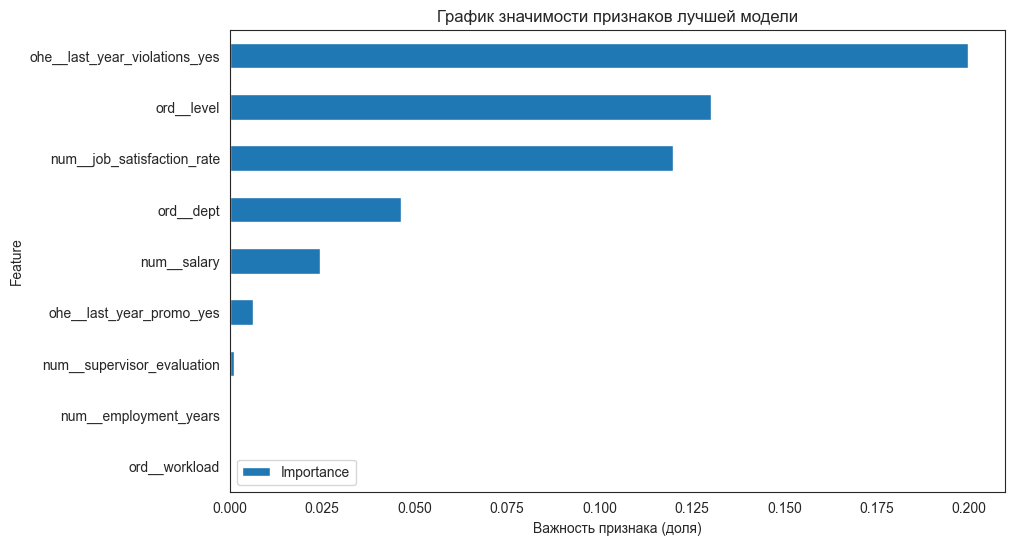

In [91]:
# Получение преобразователя из pipeline
data_preprocessor = best_model.named_steps['preprocessor']

# Применение преобразований к X_train и к X_test
X_train_transformed = data_preprocessor.transform(X_train)
X_test_transformed = data_preprocessor.transform(X_test)

permutation = permutation_importance(best_model, X_test, y_test, scoring = 'roc_auc')

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': permutation['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('График значимости признаков лучшей модели')
plt.xlabel('Важность признака (доля)')
plt.show()

Самыми важными признаками являются наличие факта нарушения трудового договора сотрудником, уровень занимаемой должности, уровень удовлетворённости сотрудника работой, отдел, в котором работает сотрудник, и зарплата.

In [92]:
# Добавим столбец `predict_quit` в таблицу X_test
data_predict = X_test.copy()
data_predict['predict_quit'] = y_test_pred

# Проверим
information(data_predict)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,predict_quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.847857,0.096154
686555,hr,junior,medium,1,no,no,4,30000,0.668235,0.244186
467458,sales,middle,low,5,no,no,4,19200,0.728571,0.059701
418655,sales,middle,low,6,no,no,4,19200,0.669130,0.059701
789145,hr,middle,medium,5,no,no,5,40800,0.777000,0.019920


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1997 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               1999 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
 9   predict_quit           2000 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 236.4+ KB


None

In [93]:
# Напишем функцию для построения диаграмм зависимости прогноза увольнения
# сотрудников с другими признаками

# функция принимает на вход количественный признак, категориальный признак, 
# название диаграммы, название оси х, название легенды
def scatter_graphic(num_sign, cat_sign, graphic_name, xlabel_name, legend_name):
    sns.scatterplot(
        data=data_predict,
        x=num_sign,
        y='predict_quit',
        hue=cat_sign,
        alpha=0.5
    )
    plt.title(graphic_name)
    plt.xlabel(xlabel_name)
    plt.ylabel('Прогноз увольнения')
    plt.legend(title=legend_name)
    plt.show()

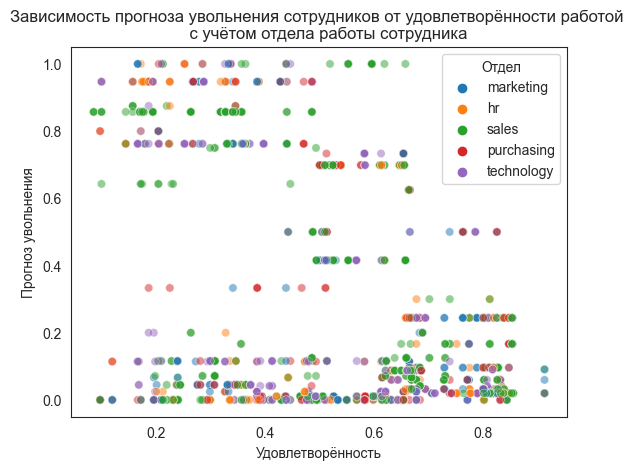

In [94]:
# Построим диаграмму рассеяния между прогнозом увольнения сотрудников
# и удовлетворённостью работой с учётом отдела работы сотрудника
scatter_graphic(
    'job_satisfaction_rate',
    'dept',
    'Зависимость прогноза увольнения сотрудников от удовлетворённости работой \n\
    с учётом отдела работы сотрудника',
    'Удовлетворённость',
    'Отдел'
)

Большинство сотрудников имеют либо очень низкую, либо очень высокую вероятность увольнения. Больше всего среди сотрудников со средней и высокой вероятностью увольнения сотрудников отдела продаж и технологического отдела.

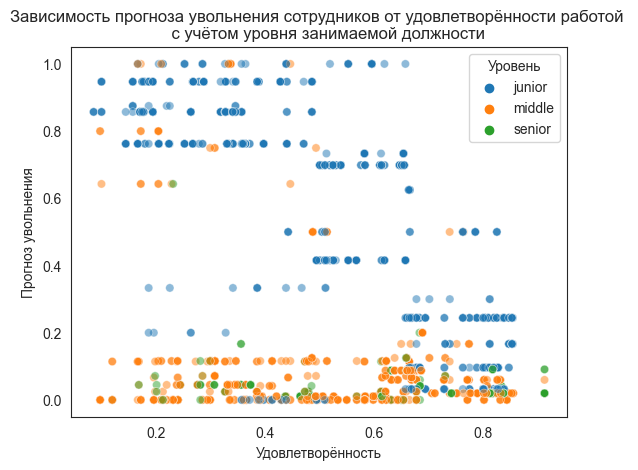

In [95]:
# Построим диаграмму рассеяния между прогнозом увольнения сотрудников
# и удовлетворённостью работой с учётом уровня занимаемой должности
scatter_graphic(
    'job_satisfaction_rate',
    'level',
    'Зависимость прогноза увольнения сотрудников от удовлетворённости работой \n\
    с учётом уровня занимаемой должности',
    'Удовлетворённость',
    'Уровень'
)

Уровень занимаемой должности очень явно влияет на прогноз увольнения. Сеньоры имеют вероятность увольнения близкую к нулю. Вероятность увольнения миддлов также невелика. А вот джуниоры составляют основную категорию сотрудников с высоким прогнозом увольнения.

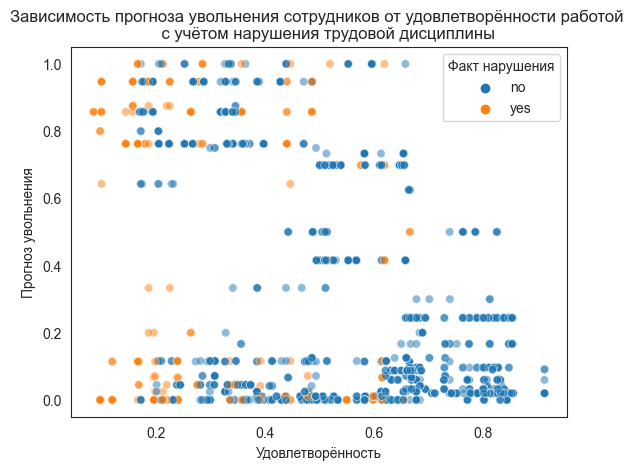

In [96]:
# Построим диаграмму рассеяния между прогнозом увольнения сотрудников
# и удовлетворённостью работой с учётом нарушения трудовой дисциплины
scatter_graphic(
    'job_satisfaction_rate',
    'last_year_violations',
    'Зависимость прогноза увольнения сотрудников от удовлетворённости работой \n\
    с учётом нарушения трудовой дисциплины',
    'Удовлетворённость',
    'Факт нарушения'
)

Факты нарушения трудовой дисциплины есть в большинстве случаев у сотрудников, которые не удовлетворены своей работой. И если не нарушавшие трудовой договор чаще не склонны увольняться, то нарушавшие трудовой договор примерно в равных пропорциях имеют высокую и низкую вероятность уволиться.

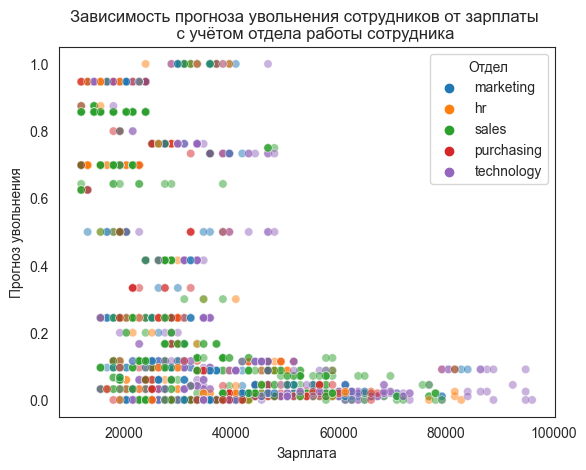

In [97]:
# Построим диаграмму рассеяния между прогнозом увольнения сотрудников
# и зарплатой с учётом отдела работы сотрудника
scatter_graphic(
    'salary',
    'dept',
    'Зависимость прогноза увольнения сотрудников от зарплаты \n\
    с учётом отдела работы сотрудника',
    'Зарплата',
    'Отдел'
)

Прогноз увольнения сотрудников касается исключительно сотрудников с зарплатой ниже среднего уровня. Сотрудники с зарплатой выше 50000 имеют вероятность увольнения не выше 0,2. Вероятность увольнения сотрудников с зарплатой ниже 40000 очень высока, а для сотрудников с зарплатой ниже 20000 увольнение почти гарантировано.  
В технологическом отделе сотрудники даже с достаточно высокой зарплатой, более 40000, имеют в ряде случаев достаточно большую вероятность увольнения. В отделе продаж большинство сотрудников имеют низкую зарплату, и вероятность увольнения таких сотрудников также высока.

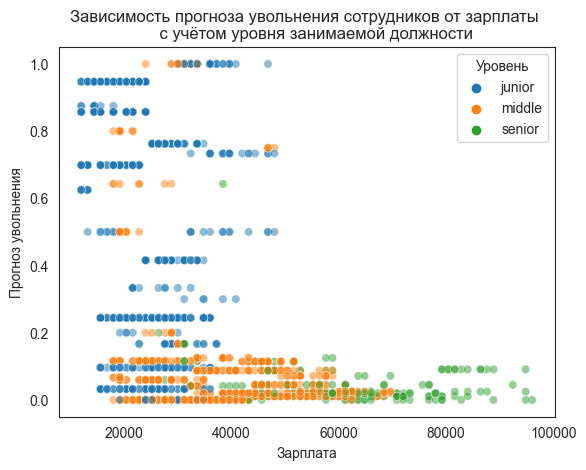

In [98]:
# Построим диаграмму рассеяния между прогнозом увольнения сотрудников
# и зарплатой с учётом уровня занимаемой должности
scatter_graphic(
    'salary',
    'level',
    'Зависимость прогноза увольнения сотрудников от зарплаты \n\
    с учётом уровня занимаемой должности',
    'Зарплата',
    'Уровень'
)

Среди сеньоров сотрудники с самой высокой зарплатой имеют нулевую вероятность увольнения, некоторую, совсем небольшую, до 0,2, вероятность увольнения имеют сеньоры с зарплатой ниже 80000.  
Среди миддлов высокую вероятность увольнения имеют некоторые сотрудники с зарплатой ниже 35000.  
А вот джуниоры, даже некоторые с зарплатой от 40000 до 50000, могут уволиться в любое время. Что касается джуниоров с зарплатой меньше 40000, и особенно меньше 30000, то большинство из них имеет очень высокую вероятность увольнения.


**Вывод.** Лучше всего справилась с задачей классификации модель дерева решений.  
Логистическая регрессия оказалась хуже потому, что лучше всего она предсказывает на линейно разделяемых классах, она неэффективна для данных с нелинейными взаимосвязями. В нашем случае большинство признаков категориальные, не имеющие линейной зависимости.   
Метод ближайших соседей умеет работать с нелинейными данными. Он по свойствам ближайших объектов определяет, как классифицировать конкретный объект. Модель рассуждает по аналогии, но аналогии не всегда правильно срабатывают, особенно, когда категориальных признаков больше, чем количественных.  
К таким данным больше всего подходит модель дерева решений. Категориальные признаки легче всего распределять на классы.  
На основе построенной модели были выделены важные признаки и проведён их анализ.

## Общий вывод
Перед нами стояли две задачи: построить модель для предсказания сотрудников работой и построить модель, которая сможет предсказать то, что сотрудник уволится из компании.  
И в первой, и во второй задаче лучше всего справились модели дерева решений, так как в исходных данных больше категориальных признаков, чем количественных.  
В первой задаче были предсказаны показатели удовлетворённости сотрудника работой, которые затем были использованы во второй задаче для предсказания факта увольнения сотрудника.  
Самыми важными признаками в полученной модели стали:

1) степень удовлетворённости сотрудников своей работой;  
2) уровень занимаемой должности;  
3) наличие факта нарушения трудовой дисциплины;  
4) отдел, в котором работает сотрудник;  
5) зарплата.  

Самым важным фактором, влияющим на вероятность увольнения, является степень удовлетворённости сотрудника работой. Чаще всего вероятность увольнения высока у сотрудников отдела продаж и технологического отдела. В отделе продаж зарплаты невысокие, что дополнительно повышает прогноз увольнения. А в технологическом отделе сотрудники даже с более высокими зарплатами, более 40000, отличаются повышенной вероятностью увольнения.  
Самый высокий прогноз увольнения у джуниоров, причём, даже у имеющих зарплату выше остальных. А джуниоры, имеющие низкую зарплату, меньше 20000, почти обязательно уволятся.  
Среди миддлов высока вероятность увольнения у сотрудников с зарплатой ниже 35000.  
Больше вероятность увольнения среди работников, нарушавших трудовую дисциплину. То есть нарушение трудовой дисциплины может служить сигналом вероятного скорого увольнения сотрудника.


Итак, чтобы уменьшить вероятность увольнения сотрудников из компании, следует:
1) обращать внимание, чтобы зарплата джуниоров не была ниже 20000, а миддлов - ниже 35000;  
2) обратить внимание на сотрудников отдела продаж и технологического отдела, на условия их работы и зарплаты;  
3) создать для джуниоров дополнительные мотивации продолжать работу: возможность дополнительного обучения, поддержку старших по уровню сотрудников, возможность повышения уровня, стимулирование саморазвития;  
4) создать условия для стремления сотрудника проявить себя с материальным стимулированием этого стремления;  
5) выявлять факты нарушения трудовой дисциплины, трактовать их как вероятное скорое увольнение сотрудника, выявлять причину и корректировать условия работы данного сотрудника, чтобы стимулировать его остаться.